# Group comparisons & Plotting

In [ ]:
#libraries
import pandas as pd
import numpy as np
import os
import sys
import joblib
import warnings
# from datetime import date, datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, norm
import scipy.stats as st
from scipy.stats import zscore as  zscore
from joblib import Parallel, delayed
# from multiprocessing import Manager
from sklearn.cross_decomposition import PLSRegression
import gc
import traceback
import logging
from sklearn.model_selection import KFold
import random

from scipy.stats import gaussian_kde
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import hcp_utils as hcp


In [ ]:
# Targets and models
targ_list = ['total_','cryst_','fluid_']
model_list = ['eN2','pls','eN1']

In [ ]:
#directories
root_dir ='/media/hcs-sci-psy-narun/ABCC/fmriresults01/derivatives/ML_Tables/nesi_outputs/std_applicability/'
plot_dir = root_dir + '/prediction_plots/'
tables_path ='/media/hcs-sci-psy-narun/ABCC/fmriresults01/derivatives/ML_Tables/'
if not os.path.isdir(root_dir):
    os.mkdir(root_dir) 
if not os.path.isdir(plot_dir):
    os.mkdir(plot_dir) 

In [ ]:
# ABCD NIH toolbox cognitive scores for each group 
T1 = pd.read_csv(tables_path+'cog_tables/cog_t1.csv', index_col=0)
T1.index = T1.index.str.replace('_', '')
T2 = pd.read_csv(tables_path+'cog_tables/cog_t2.csv', index_col=0)
T2.index = T2.index.str.replace('_', '')
T3 = pd.read_csv(tables_path+'cog_tables/cog_t3.csv', index_col=0)
T3.index = T3.index.str.replace('_', '')
T4 = pd.read_csv(tables_path+'cog_tables/cog_t4.csv', index_col=0)
T4.index = T4.index.str.replace('_', '')
non = pd.read_csv(tables_path+'cog_tables/cog_non.csv', index_col=0)
non.index = non.index.str.replace('_', '')
All = pd.read_csv(tables_path+'cog_tables/cog_all.csv', index_col=0)
All.index = All.index.str.replace('_', '')

In [ ]:
#WISC-II cognitive scores for each group 
adhd_cog2 = pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/cog_adhd2.csv', index_col=0)
non_cog2 = pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/cog_non2.csv', index_col=0)
all_cog2 = pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds003500-download/derivatives/ML_Tables/cog.csv', index_col=0)

adhd_cog2.index = adhd_cog2.index.str.replace('sub-', '')
non_cog2.index = non_cog2.index.str.replace('sub-', '')
all_cog2.index = all_cog2.index.str.replace('sub-', '')

adhd_cog1 = pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/cog_adhd1.csv', index_col=0)
non_cog1 = pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/cog_non1.csv', index_col=0)
all_cog1 = pd.read_csv('/media/hcs-sci-psy-narun/OpenNEURO_adhd/ds002424-download/derivatives/ML_Tables/cog.csv', index_col=0)
adhd_cog1.index = adhd_cog1.index.str.replace('sub-', '')
non_cog1.index = non_cog1.index.str.replace('sub-', '')
all_cog1.index = all_cog1.index.str.replace('sub-', '')

In [ ]:
#ABCD stack model label meanings 
stacked_labels = {
    # 'All1' : 'DTI + abcc+abcd r/smri + task and rest FC + g/tFC + cntr',
    # 'All2' : ' DTI + abcc r/smri + task and rest FC + cntr ',
    # 'All3' : 'DTI + abcc r/smri + task and rest FC',
    # 'All4' : 'DTI + abcc r/smri + task and rest FC + gFC + cntr',
    # 'All5' : 'DTI + abcc r/smri + task and rest FC + tFC + cntr',
    # 'All6' : 'DTI + abcc r/smri + rest FC + tFC + cntr',
    # 'All7' : 'DTI + abcc r/smri + rest FC + gFC + cntr',
    'All8' : 'ABCC sMRI + Multitask FC + Nback WM Load Contrasts',
    'All9' : 'ABCC sMRI + General FC + Nback WM Load Contrasts',
    'All10' : 'ABCC sMRI + Nback FC + Nback WM Load Contrasts',
    'nAll1_abcd' : 'Stacked all', #'DTI + abcd+abcc r/smri + task and rest FC + g/tFC + abcd+abcc cntr',
    # 'All2_abcd' : 'DTI + abcd+abcc r/smri + task and rest FC + g/tFC + abcd cntr',
    'AllRest' : 'Rest FCs', #
    'nGD_TaskCntr' : 'Task Contrasts',#'cntr', just Glasser
    # 'TaskCntr' : 'G Task Contrasts',
    'AllSmri' : 'sMRI',#'abcc+abcd smri',
    'NonTask' : 'Non-Task',#'abcc+abcd smri + rest FC',
    'AllFCs' : 'All FCs',
    'TaskConn' : 'Task FCs',
    'nGD_TaskAll' : 'Task FCs + Contrasts',
    # 'StrConn' : 'sMRI + Task and Rest FC',
    # 'StrtFC' : 'sMRI + task FC',
    # 'StrgFC' : 'sMRI + general FC',
    'PrConn' : 'ABCC Task and Rest FCs', #'conn_rest', 'conn_wm', 'conn_sst', 'conn_mid'
    'nGD_WMCntr' : 'Nback Contrasts',#Glass
    'GD_SstCntr' : 'SST Contrasts',#Glass
    'nGD_MidCntr' : 'MID Contrasts', #Glass
    'nGD_WMAll' : 'Nback Contrasts + FC', # glasser
    'nGD_SstAll' : 'SST Contrasts + FC', # Glasser
    'nGD_MidAll' : 'MID Contrasts + FC', #Glasser
    'Str2' : 'ABCC sMRI',
    'WmCntr2' : 'Nback WM Load Contrasts',
}

In [ ]:
#single modality label meanings 
l1_labels = {
    'conn_mid': 'MID FC',
    'gfc': 'General FC',
    'tfc': 'Multitask FC',
    # 'tang_MID': 'MID FC (tangent)',
    # 'tang_rest': 'rsfMRI FC (tangent)',
    'conn_rest': 'rest FC',
    #'cntr_twobk-zerobk_task-nback': 'Glasser Nback 2-0back',
    # 'tang_SST': 'SST FC (tangent)',
    #'cntr_twobk_task-nback': 'Glasser Nback 2back',
    #'cntr_zerobk_task-nback': 'Glasser Nback 0back',
    # 'tang_WM': 'nback FC (tangent)',
    'conn_wm': 'Nback FC',
    'conn_sst': 'SST FC',
    #'cntr_Loss-Neutral_task-MID': 'Glasser MID Loss-Neutral',
    #'cntr_Reward-Neutral_task-MID': 'Glasser MID Reward-Neutral',
    #'cntr_face_task-nback': 'Glasser Nback Face',
    # 'part_rest': 'rsfMRI FC (partial)',
    #'cntr_emotionface_task-nback': 'Glasser Nback Emotionface',
    #'cntr_place_task-nback': 'Glasser Nback Place',
    #'cntr_LgReward-Neutral_task-MID': 'Glasser MID LargeReward-Neutral',
    #'cntr_face-place_task-nback': 'Glasser Nback Face-Place',
    #'cntr_LgLoss-Neutral_task-MID': 'Glasser MID LargeLoss-Neutral',
    # 'avg_rest': 'rsfMRI temporal variance',
    #'cntr_SmallLoss-Neutral_task-MID': 'Glasser MID SmallLoss-Neutral',
    #'cntr_LossHit-LossMiss_task-MID': 'Glasser MID LossHit-LossMiss ',
    'T2_gray': 'T2 Gray Matter Avg Intensity',
    #'cntr_SmallReward-Neutral_task-MID': 'Glasser MID SmallReward-Neutral',
    #'cntr_emotionface-NeutFace_task-nback': 'Glasser Nback Emotionface-Neutralface',
    'subnet_rest': 'rs-fMRI Subcortical-network FC',
    'cntr_Stop-CorrectGo_task-SST': 'Glasser SST Stop-CorrectGo',
    # 'part_mid': 'MID FC (partial)' ,
    #'cntr_RewardHit-RewardMiss_task-MID': 'Glasser MID RewardHit-RewardMiss',
    'T1_gray': ' T1 Gray Matter Avg Intensity',
    # 'part_sst': 'SST FC (partial)',
    'T2_white': ' T2 White Matter Avg Intensity',
    'cntr_IncorrectStop-CorrectGo_task-SST': 'Glasser SST IncorrectStop-CorrectGo',
    'cntr_IncorrectGo_task-SST': 'Glasser SST IncorrectGo',
    'cntr_IncorrectStop_task-SST': 'Glasser SST IncorrectStop',
    # 'cort': 'Cortical thickness',
    'cntr_IncorrectGo-CorrectGo_task-SST': 'Glasser SST IncorrectGo-CorrectGo',
    'T1_norm': 'T1 Normalised Intensity',
    'cntr_CorrectStop_task-SST': 'Glasser SST CorrectStop',
    'T1_white': ' T1 White Matter Avg Intensity',
    'T2_norm': 'T2 Normalised Intensity',
    'cntr_CorrectStop-CorrectGo_task-SST': 'Glasser SST CorrectStop-CorrectGo',
    'surf': 'Surface Area',
    'cntr_IncorrectGo-IncorrectStop_task-SST': 'Glasser SST IncorrectGo-IncorrectStop',
    #'cntr_LgReward-SmallReward_task-MID': 'Glasser MID LargeReward-SmallReward',
    # 'part_wm': 'Nback FC (partial)',
    'cntr_CorrectGo_task-SST': 'Glasser SST CorrectGo',
    'cntr_CorrectStop-IncorrectStop_task-SST': 'Glasser SST CorrectStop-IncorrectStop',
    'T1_summ': 'T1 Summations',
    #'cntr_LgLoss-SmallLoss_task-MID': 'Glasser MID LargeLoss-SmallLoss',
    # 'subc': 'Subcortical volume',
    'VolBrain': 'FreeSurfer Summations',
    'DTI': 'DTI',
    #'cntr_NegFace-NeutFace_task-nback': 'Glasser Nback NegFace-NeutFace ',
    #'cntr_PosFace-NeutFace_task-nback': 'Glasser Nback PosFace-NeutFace ',
    'T2_summ': 'T2 Summations',
    'Sulcal_Depth': 'Sulcal Depth',
    'Avg_T1_ASEG_Vol_': 'T1 Subcortical Volume',
    # 'Dest_Area_': 'Destriuex surface area',
    'Dest_Thick_': 'Cortical Thickness',
    'Avg_T2_ASEG_': 'T2 Subcortical Volume',
    # 'Vol_ASEG_': '',
    'rsmri_within_avg_data': 'rs-fMRI cortical FC',
    'Dest_Vol_': 'Cortical Volume',
    'rsmri_gordon_aseg_data': 'rs-fMRI Temporal Variance',
    'antiLargeRewVsSmallRew_ROI_mid': 'Destriuex MID LargeReward-SmallReward',
    'feedPunPosVsNeg_ROI_mid': 'Destriuex MID LossHit-LossMiss',
    'incorrectgovsincorrectstop_ROI_sst': 'Destriuex SST IncorrectGo-IncorrectStop',
    'anystopvscorrectgo_ROI_sst': 'Destriuex SST AnyStop-CorrectStop',
    'incorrectstopvscorrectgo_ROI_sst': 'Destriuex SST IncorrectStop-CorrectGo',
    'emotionvsneutface_ROI_nbk': 'Destriuex Nback EmotionFace-NeutFace',
    'incorrectgovscorrectgo_ROI_sst': 'Destriuex SST IncorrectGo-CorrectGo',
    'correctgovsfixation_ROI_sst': 'Destriuex SST CorrectGo-Fixation',
    'antiRewVsNeu_ROI_mid': 'Destriuex MID Reward-Neutral',
    'X2back_ROI_nbk': 'Destriuex Nback 2back',
    'facevsplace_ROI_nbk': 'Destriuex Nback Face-Place',
    'antiSmallLossVsNeu_ROI_mid': 'Destriuex MID SmallLoss-Neutral',
    'negfacevsneutface_ROI_nbk': 'Destriuex Nback NegFace-NeutFace',
    'antiLargeLossVsNeu_ROI_mid': 'Destriuex MID LargeLoss-Neutral',
    'emotion_ROI_nbk': 'Destriuex Nback EmotionFace',
    'correctstopvsincorrectstop_ROI_sst': 'Destriuex SST CorrectStop-IncorrectStop',
    'antiSmallRewVsNeu_ROI_mid': 'Destriuex MID SmallReward-Neutral',
    'antiLargeRewVsNeu_ROI_mid': 'Destriuex MID LargeReward-Neutral',
    'antiLosVsNeu_ROI_mid': 'Destriuex MID Loss-Neutral',
    'correctstopvscorrectgo_ROI_sst': 'Destriuex SST CorrectStop-CorrectGo',
    'posfacevsneutface_ROI_nbk': 'Destriuex Nback PosFace-NeutFace',
    'X0back_ROI_nbk': 'Destriuex Nback 0back',
    'place_ROI_nbk': 'Destriuex Nback Place',
    'antiLargeLossVsSmallLoss_ROI_mid': 'Destriuex MID LargeLoss-SmallLoss',
    'X2backvs0back_ROI_nbk': 'Destriuex Nback 2-0back',
    'feedRewPosVsNeg_ROI_mid': 'Destriuex MID RewardHit-RewardMiss',
    'artr_twobk_task-nback': 'Glasser Nback 2back',
    'artr_LossHit-LossMiss_task-MID': 'Glasser MID LossHit-LossMiss',
    'artr_SmallLoss-Neutral_task-MID':'Glasser MID SmallLoss-Neutral',
    'artr_LgReward-SmallReward_task-MID':'Glasser MID LargeReward-SmallReward',
    'artr_Loss-Neutral_task-MID':'Glasser MID Loss-Neutral',
    'artr_PosFace-NeutFace_task-nback': 'Glasser Nback PosFace-NeutFace',
    'artr_LgLoss-Neutral_task-MID':'Glasser MID LargeLoss-Neutral',
    'artr_NegFace-NeutFace_task-nback': 'Glasser Nback NegFace-NeutFace',
    'artr_face-place_task-nback': 'Glasser Nback Face-Place',
    'artr_LgReward-Neutral_task-MID':'Glasser MID LargeReward-Neutral',
    'artr_RewardHit-RewardMiss_task-MID':'Glasser MID RewardHit-RewardMiss',
    'artr_place_task-nback': 'Glasser Nback Place',
    'artr_twobk-zerobk_task-nback': 'Glasser Nback 2-0back',
    'artr_LgLoss-SmallLoss_task-MID':'Glasser MID LargeLoss-SmallLoss',
    'artr_face_task-nback': 'Glasser Nback Face',
    'artr_emotionface_task-nback': 'Glasser Nback EmotionFace',
    'artr_emotionface-NeutFace_task-nback': 'Glasser Nback Emotionface-NeutFace',
    'artr_zerobk_task-nback': 'Glasser Nback 0back',
    'artr_SmallReward-Neutral_task-MID':'Glasser MID SmallReward-Neutral',
    'artr_Reward-Neutral_task-MID':'Glasser MID Reward-Neutral'
}

In [ ]:
#All  layers modality label meanings 
l12_labels = {
    'conn_mid': 'MID FC',
    'gfc': 'General FC',
    'tfc': 'Multitask FC',
    # 'tang_MID': 'MID FC (tangent)',
    # 'tang_rest': 'rsfMRI FC (tangent)',
    'conn_rest': 'Glasser \nrest FC',
    'artr_twobk-zerobk_task-nback': 'Glasser \nNback 2-0back',
    # 'tang_SST': 'SST FC (tangent)',
    'cntr_twobk_task-nback': 'Glasser Nback 2back',
    'cntr_zerobk_task-nback': 'Glasser Nback 0back',
    # 'tang_WM': 'nback FC (tangent)',
    'conn_wm': 'Glasser Nback FC (full)',
    'conn_SST': 'Glasser SST FC (full)',
    'cntr_Loss-Neutral_task-MID': 'Glasser MID Loss-Neutral',
    'cntr_Reward-Neutral_task-MID': 'Glasser MID Reward-Neutral',
    'cntr_face_task-nback': 'Glasser Nback face',
    # 'part_rest': 'rsfMRI FC (partial)',
    'cntr_emotionface_task-nback': 'Glasser Nback emotionface',
    'cntr_place_task-nback': 'Glasser Nback place',
    'cntr_LgReward-Neutral_task-MID': 'Glasser MID LargeReward-Neutral',
    'cntr_face-place_task-nback': 'Glasser Nback face-place',
    'cntr_LgLoss-Neutral_task-MID': 'Glasser MID LargeLoss-Neutral',
    'avg_rest': 'rsfMRI temporal variance',
    'cntr_SmallLoss-Neutral_task-MID': 'Glasser MID SmallLoss-Neutral',
    'cntr_LossHit-LossMiss_task-MID': 'Glasser MID LossHit-LossMiss ',
    'T2_gray': 'T2 Gray Matter \nIntensity',
    'cntr_SmallReward-Neutral_task-MID': 'Glasser MID SmallReward-Neutral',
    'cntr_emotionface-NeutFace_task-nback': 'Glasser Nback emotionface-neutralface',
    'subnet_rest': 'rsfMRI subcortical-network FC',
    'cntr_Stop-CorrectGo_task-SST': 'Glasser SST Stop-CorrectGo',
    # 'part_mid': 'MID FC (partial)' ,
    'cntr_RewardHit-RewardMiss_task-MID': 'Glasser MID RewardHit-RewardMiss',
    'T1_gray': ' T1 GM avg intensity',
    # 'part_sst': 'SST FC (partial)',
    'T2_white': ' T2 white matter avg intensity',
    'cntr_IncorrectStop-CorrectGo_task-SST': 'Glasser SST IncorrectStop-CorrectGo',
    'cntr_IncorrectGo_task-SST': 'Glasser SST IncorrectGo',
    'cntr_IncorrectStop_task-SST': 'Glasser SST IncorrectStop',
    'cort': 'Cortical thickness',
    'cntr_IncorrectGo-CorrectGo_task-SST': 'Glasser SST IncorrectGo-CorrectGo',
    'T1_norm': 'T1 normalised intensity',
    'cntr_CorrectStop_task-SST': 'Glasser SST CorrectStop',
    'T1_white': ' T1 white matter avg intensity',
    'T2_norm': 'T2 normalised intensity',
    'cntr_CorrectStop-CorrectGo_task-SST': 'Glasser SST CorrectStop-CorrectGo',
    'surf': 'Surface area',
    'cntr_IncorrectGo-IncorrectStop_task-SST': 'Glasser SST IncorrectGo-IncorrectStop',
    'cntr_LgReward-SmallReward_task-MID': 'Glasser MID LargeReward-SmallReward',
    # 'part_wm': 'Nback FC (partial)',
    'cntr_CorrectGo_task-SST': 'Glasser SST CorrectGo',
    'cntr_CorrectStop-IncorrectStop_task-SST': 'Glasser SST CorrectStop-IncorrectStop',
    'T1_summ': 'T1 summations',
    'cntr_LgLoss-SmallLoss_task-MID': 'Glasser MID LargeLoss-SmallLoss',
    'subc': 'Subcortical volume',
    'VolBrain': 'FreeSurfer Summations',
    'DTI': 'DTI',
    'cntr_NegFace-NeutFace_task-nback': 'Glasser Nback NegFace-NeutFace ',
    'cntr_PosFace-NeutFace_task-nback': 'Glasser Nback PosFace-NeutFace ',
    'T2_summ': 'T2 summations',
    'Sulcal_Depth': 'Sulcal depth',
    'Avg_T1_ASEG_Vol_': 'T1 Average Volume',
    # 'Dest_Area_': 'Destriuex surface area',
    'Dest_Thick_': 'Destriuex cortical thickness',
    'Avg_T2_ASEG_': 'T2 Average Volume',
    # 'Vol_ASEG_': '',
    # 'rsmri_within_avg_data': '',
    # 'Dest_Vol_': 'Destriuex Volume',
    'rsmri_gordon_aseg_data': 'rsfMRI cortical FC',
    'antiLargeRewVsSmallRew_ROI_mid': 'Destriuex MID LargeReward-SmallReward',
    'feedPunPosVsNeg_ROI_mid': 'Destriuex MID LossHit-LossMiss',
    'incorrectgovsincorrectstop_ROI_sst': 'Destriuex SST IncorrectGo-IncorrectStop',
    'anystopvscorrectgo_ROI_sst': 'Destriuex SST AnyStop-CorrectStop',
    'incorrectstopvscorrectgo_ROI_sst': 'Destriuex SST IncorrectStop-CorrectGo',
    'emotionvsneutface_ROI_nbk': 'Destriuex Nback emotionface-neutralface',
    'incorrectgovscorrectgo_ROI_sst': 'Destriuex SST IncorrectGo-CorrectGo',
    'correctgovsfixation_ROI_sst': 'Destriuex SST CorrectGo-fixation',
    'antiRewVsNeu_ROI_mid': 'DestriuexMID Reward-Neutral',
    'X2back_ROI_nbk': 'Destriuex Nback 2-0back',
    'facevsplace_ROI_nbk': 'Destriuex Nback face-place',
    'antiSmallLossVsNeu_ROI_mid': 'Destriuex MID SmallLoss-Neutral',
    'negfacevsneutface_ROI_nbk': 'Destriuex Nback NegFace-NeutFace',
    'antiLargeLossVsNeu_ROI_mid': 'Destriuex MID LargeLoss-Neutral',
    'emotion_ROI_nbk': 'Destriuex Nback emotionface',
    'correctstopvsincorrectstop_ROI_sst': 'Destriuex SST CorrectStop-IncorrectStop',
    'antiSmallRewVsNeu_ROI_mid': 'Destriuex MID SmallReward-Neutral',
    'antiLargeRewVsNeu_ROI_mid': 'Destriuex MID LargeReward-Neutral',
    'antiLosVsNeu_ROI_mid': 'Destriuex MID Loss-Neutral',
    'correctstopvscorrectgo_ROI_sst': 'Destriuex SST CorrectStop-CorrectGo',
    'posfacevsneutface_ROI_nbk': 'Destriuex Nback PosFace-NeutFace',
    'X0back_ROI_nbk': 'Destriuex Nback 0back',
    'place_ROI_nbk': 'Destriuex Nback place',
    'antiLargeLossVsSmallLoss_ROI_mid': 'Destriuex MID LargeLoss-SmallLoss',
    'X2backvs0back_ROI_nbk': 'Destriuex Nback 2-0back',
    'feedRewPosVsNeg_ROI_mid': 'Destriuex MID RewardHit-RewardMiss',
    # 'All1' : 'DTI + abcc+abcd r/smri + task and rest FC + g/tFC + cntr',
    # 'All2' : ' DTI + abcc r/smri + task and rest FC + cntr ',
    # 'All3' : 'DTI + abcc r/smri + task and rest FC',
    # 'All4' : 'DTI + abcc r/smri + task and rest FC + gFC + cntr',
    # 'All5' : 'DTI + abcc r/smri + task and rest FC + tFC + cntr',
    # 'All6' : 'DTI + abcc r/smri + rest FC + tFC + cntr',
    # 'All7' : 'DTI + abcc r/smri + rest FC + gFC + cntr',
    # 'All8' : 'abcc smri + tFC + nback 2-0 contrasts',
    # 'All9' : 'abcc smri + gFC + nback 2-0 contrasts',
    # 'All10' : 'abcc smri + nback FC + nback 2-0 contrasts',
    'All1_abcd' : 'Stacked All', #'DTI + abcd+abcc r/smri + task and rest FC + g/tFC + abcd+abcc cntr',
    # 'All2_abcd' : 'DTI + abcd+abcc r/smri + task and rest FC + g/tFC + abcd cntr',
    # 'FC' : 'Functional connectivity', #'g/tFC',
    'TaskCntr' : 'Task contrasts',#'cntr',
    'Str' : 'sMRI',#'abcc+abcd smri',
    'StrRest' : 'sMRI + Rest FC',#'abcc+abcd smri + rest FC',
    # 'StrRest2' : 'abcc smri + rest FC',
    'TaskConn' : 'Task FC',
    'TaskAll' : 'Task FC + contrasts',
    'StrConn' : 'sMRI + Task and Rest FC',
    # 'StrtFC' : 'sMRI + task FC',
    'StrgFC' : 'sMRI + general FC',
    'PrConn' : 'Task and Rest FC',
    'WmCntr' : 'Nback contrasts',
    'SstCntr' : 'SST contrasts',
    'MidCntr' : 'MID contrasts',
    'WmAll' : 'Nback contrasts + FC', 
    'SstAll' : 'SST contrasts + FC', 
    'MidAll' : 'MID contrasts + FC', 
    # 'Str2' : 'abcc smri',
    # 'WmCntr2' : 'nback 2-0 contrasts',
}

## 1. Bootsrapped difference in performance between groups

In [ ]:
#bootstrap func
def bootstrappin(group, all_predicted):
    # print(group.shape)
    # compute meaures
    p_corr, _ = pearsonr(group, all_predicted)
    r2 = r2_score(group, all_predicted)
    rmse = np.sqrt(mean_squared_error(group, all_predicted))
    mae = mean_absolute_error(group, all_predicted)


    return p_corr, r2, rmse, mae

## ABCD

In [ ]:
# ABCD bootsrtap parrallel
import joblib
import numpy as np
from typing import Dict, Any
from scipy.stats.mstats import winsorize

def process_modality(modality, group_dict, num_samples):
    modality_results = {'pr': {}, 'r2': {}, 'rmse': {}, 'mae': {}}

    for group, plot_obj in group_dict.items():
        if 'Tier' in group:
            yp_all = plot_obj[-2][1]
            yt_all = plot_obj[-2][0]
            diff_mae_bootstrap = np.zeros(num_samples)
            diff_rmse_bootstrap = np.zeros(num_samples)
            diff_r2_bootstrap = np.zeros(num_samples)
            diff_pr_bootstrap = np.zeros(num_samples)

            adhd_pred_ind = yp_all.index
            non_pred_ind = group_dict['non-ADHD'][-2][1].index


            for i in range(num_samples):
                resampled_indices_adhd = np.random.choice(adhd_pred_ind, size=1000, replace=True)
                resampled_indices_non_adhd = np.random.choice(non_pred_ind, size=1000, replace=True)

                true_adhd = yt_all.loc[resampled_indices_adhd].values.flatten()
                true_non_adhd = group_dict['non-ADHD'][-2][0].loc[resampled_indices_non_adhd].values.flatten()

                resampled_predictions_adhd = yp_all.loc[resampled_indices_adhd].values.flatten()
                resampled_predictions_non_adhd = group_dict['non-ADHD'][-2][1].loc[resampled_indices_non_adhd].values.flatten()

                pr_adhd1, r2_adhd1, rmse_adhd1, mae_adhd1 = bootstrappin(true_adhd, resampled_predictions_adhd)
                pr_non, r2_non, rmse_non, mae_non = bootstrappin(true_non_adhd, resampled_predictions_non_adhd)

                diff_mae_bootstrap[i] = mae_adhd1 - mae_non
                diff_rmse_bootstrap[i] = rmse_adhd1 - rmse_non
                diff_r2_bootstrap[i] = r2_adhd1 - r2_non
                diff_pr_bootstrap[i] = pr_adhd1 - pr_non

            confidence_interval_mae = np.percentile(diff_mae_bootstrap, [2.5, 97.5])
            mae_comp = (1 if confidence_interval_mae[0] > 0 and confidence_interval_mae[1] > 0 else
                        -1 if confidence_interval_mae[0] < 0 and confidence_interval_mae[1] < 0 else 0)
            confidence_interval_rmse = np.percentile(diff_rmse_bootstrap, [2.5, 97.5])
            rmse_comp = (1 if confidence_interval_rmse[0] > 0 and confidence_interval_rmse[1] > 0 else
                        -1 if confidence_interval_rmse[0] < 0 and confidence_interval_rmse[1] < 0 else 0)
            confidence_interval_r2 = np.percentile(diff_r2_bootstrap, [2.5, 97.5])
            r2_comp = (1 if confidence_interval_r2[0] > 0 and confidence_interval_r2[1] > 0 else
                       -1 if confidence_interval_r2[0] < 0 and confidence_interval_r2[1] < 0 else 0)
            confidence_interval_pr = np.percentile(diff_pr_bootstrap, [2.5, 97.5])
            pr_comp = (1 if confidence_interval_pr[0] > 0 and confidence_interval_pr[1] > 0 else
                       -1 if confidence_interval_pr[0] < 0 and confidence_interval_pr[1] < 0 else 0)

            modality_results['pr'][group] = [pr_comp, confidence_interval_pr]
            modality_results['r2'][group] = [r2_comp, confidence_interval_r2]
            modality_results['rmse'][group] = [rmse_comp, confidence_interval_rmse]
            modality_results['mae'][group] = [mae_comp, confidence_interval_mae]

    return modality, modality_results

def bootstrap_analysis(model, targ, plot_dir, num_samples=1000):
    corr_results = joblib.load(plot_dir + targ + model + '_corr_res.joblib')
    boot_results_dict = {'pr': {}, 'r2': {}, 'rmse': {}, 'mae': {}}
    for set_name, modality_dict in corr_results.items():
        parallel_results = joblib.Parallel(n_jobs=-1)(
            joblib.delayed(process_modality)(modality, group_dict, num_samples)
            for modality, group_dict in modality_dict.items()
        )

    for modality, results in parallel_results:
        for metric, group_data in results.items():
            if metric not in boot_results_dict:
                boot_results_dict[metric] = {}
            for group, data in group_data.items():
                if group not in boot_results_dict[metric]:
                    boot_results_dict[metric][group] = {}
                boot_results_dict[metric][group][modality] = data

    joblib.dump(boot_results_dict, f"{plot_dir}{targ}{model}_boot_res.joblib")

def main(targ_list, model_list, plot_dir, num_samples=1000):
    joblib.Parallel(n_jobs=-1)(
        joblib.delayed(bootstrap_analysis)(model, targ, plot_dir, num_samples)
        for model in model_list
        for targ in targ_list
        
    )

targ_list = ['total_', 'cryst_', 'fluid_']
model_list = ['ntrf2'] # 'eN1'
num_samples = 2000

main(targ_list, model_list, plot_dir, num_samples)


## Lytle

In [ ]:
# Lytle bootsrtap parrallel
targ_list = ['VIQ_', 'PIQ_', 'FSIQ_']
test_set = '_op1' #'op2_'
model_list = ['enet1_output_fstd'] #rf2_output_fstd
# Number of bootstrap samples
num_samples = 1000
for model in model_list:
      for targ in targ_list:
            corr_results = joblib.load(plot_dir  + targ + model + test_set + '_corr_res.joblib')

            boot_results_dict = {'pr':{'ADHD':{}},'r2':{'ADHD':{}},
                                 'mae':{'ADHD':{}},'rmse':{'ADHD':{}}}

            for set_name, modality_dict in corr_results.items():
               # Iterate over modalities
                  for i, (modality, group_dict) in enumerate(modality_dict.items()):
                    # Iterate over groups
                        for j, (group, plot_obj) in enumerate(group_dict.items()):
                              if group == 'ADHD':
                                    yp_all = plot_obj[-2][1]
                                    yt_all = plot_obj[-2][0]
                                    # new_row = pd.Series([None] * len(prediction_results.columns), index=prediction_results.columns)
                                    diff_mae_bootstrap = np.zeros(num_samples)
                                    diff_rmse_bootstrap = np.zeros(num_samples)
                                    diff_r2_bootstrap = np.zeros(num_samples)
                                    diff_pr_bootstrap = np.zeros(num_samples)

                              
                                    for i in range(num_samples):
                                          tar = targ[0:4]
                                          adhd_pred_ind = yp_all.index
                                          non_pred_ind = group_dict['non-ADHD'][-2][1].index

                                          # Sample indices with replacement for both groups
                                          resampled_indices_adhd = np.random.choice(adhd_pred_ind, size= 200 , replace=True)#len(adhd_pred_ind)
                                          resampled_indices_non_adhd = np.random.choice(non_pred_ind, size= 200 , replace=True)#len(adhd_pred_ind)
                                          
                                          # Select true values corresponding to the sampled indices
                                          true_adhd = yt_all.loc[resampled_indices_adhd].values.flatten()
                                          true_non_adhd = group_dict['non-ADHD'][-2][0].loc[resampled_indices_non_adhd].values.flatten()
                                          
                                          # Sample predictions using the sampled indices
                                          resampled_predictions_adhd = yp_all.loc[resampled_indices_adhd].values.flatten()
                                          resampled_predictions_non_adhd = group_dict['non-ADHD'][-2][1].loc[resampled_indices_non_adhd].values.flatten()


                                          pr_adhd1 , r2_adhd1, rmse_adhd1, mae_adhd1  = bootstrappin(true_adhd, resampled_predictions_adhd)
                                          pr_non, r2_non, rmse_non, mae_non  = bootstrappin(true_non_adhd, resampled_predictions_non_adhd)
                                          # Compute the difference in performance metrics
                                          diff_mae_bootstrap[i] = mae_adhd1 - mae_non
                                          diff_rmse_bootstrap[i] = rmse_adhd1 - rmse_non
                                          diff_r2_bootstrap[i] = r2_adhd1 - r2_non
                                          diff_pr_bootstrap[i] = pr_adhd1 - pr_non
                                    # Compute confidence intervals using percentiles
                                    confidence_interval_mae = np.percentile(diff_mae_bootstrap, [2.5, 97.5])
                                    mae_comp = (1 if confidence_interval_mae[0] > 0 and confidence_interval_mae[1] > 0 else
                                                                  -1 if confidence_interval_mae[0] < 0 and confidence_interval_mae[1] < 0 else 0)
                                    confidence_interval_rmse = np.percentile(diff_rmse_bootstrap, [2.5, 97.5])
                                    rmse_comp = (1 if confidence_interval_rmse[0] > 0 and confidence_interval_rmse[1] > 0 else
                                                                  -1 if confidence_interval_rmse[0] < 0 and confidence_interval_rmse[1] < 0 else 0)
                                    confidence_interval_r2 = np.percentile(diff_r2_bootstrap, [2.5, 97.5])
                                    r2_comp = (1 if confidence_interval_r2[0] > 0 and confidence_interval_r2[1] > 0 else
                                                                  -1 if confidence_interval_r2[0] < 0 and confidence_interval_r2[1] < 0 else 0)
                                    confidence_interval_pr = np.percentile(diff_pr_bootstrap, [2.5, 97.5])
                                    pr_comp = (1 if confidence_interval_pr[0] > 0 and confidence_interval_pr[1] > 0 else
                                                                  -1 if confidence_interval_pr[0] < 0 and confidence_interval_pr[1] < 0 else 0)
                                    
                                    boot_results_dict['pr'][group][modality] = [pr_comp, confidence_interval_pr]
                                    boot_results_dict['r2'][group][modality] = [r2_comp, confidence_interval_r2]
                                    boot_results_dict['rmse'][group][modality] = [rmse_comp, confidence_interval_rmse]
                                    boot_results_dict['mae'][group][modality] = [mae_comp, confidence_interval_mae]
                        
                        

                  # prediction_results = prediction_results.append(new_row, ignore_index=True)
                  # prediction_results.to_csv(plot_dir  + targ + model + '_bootstrapping_comparison.csv')
                        # print("95% Confidence Interval for Difference in MAE:", targ, f_name, confidence_interval_mae)
                        # print("95% Confidence Interval for Difference in RMSE:", targ, f_name, confidence_interval_rmse)
                        # print("95% Confidence Interval for Difference in R2:", targ, f_name, confidence_interval_r2)
                        # print("95% Confidence Interval for Difference in R:", targ, f_name, confidence_interval_pr)
            # prediction_results.to_csv(plot_dir  + targ + model + '_predictive_ability.csv')
            joblib.dump(boot_results_dict, plot_dir  + targ + model + test_set + '_boot_res.joblib')

## 2. Dot plot 
### bootsrapped correlation/difference between ADHD - non-ADHD

## ABCD

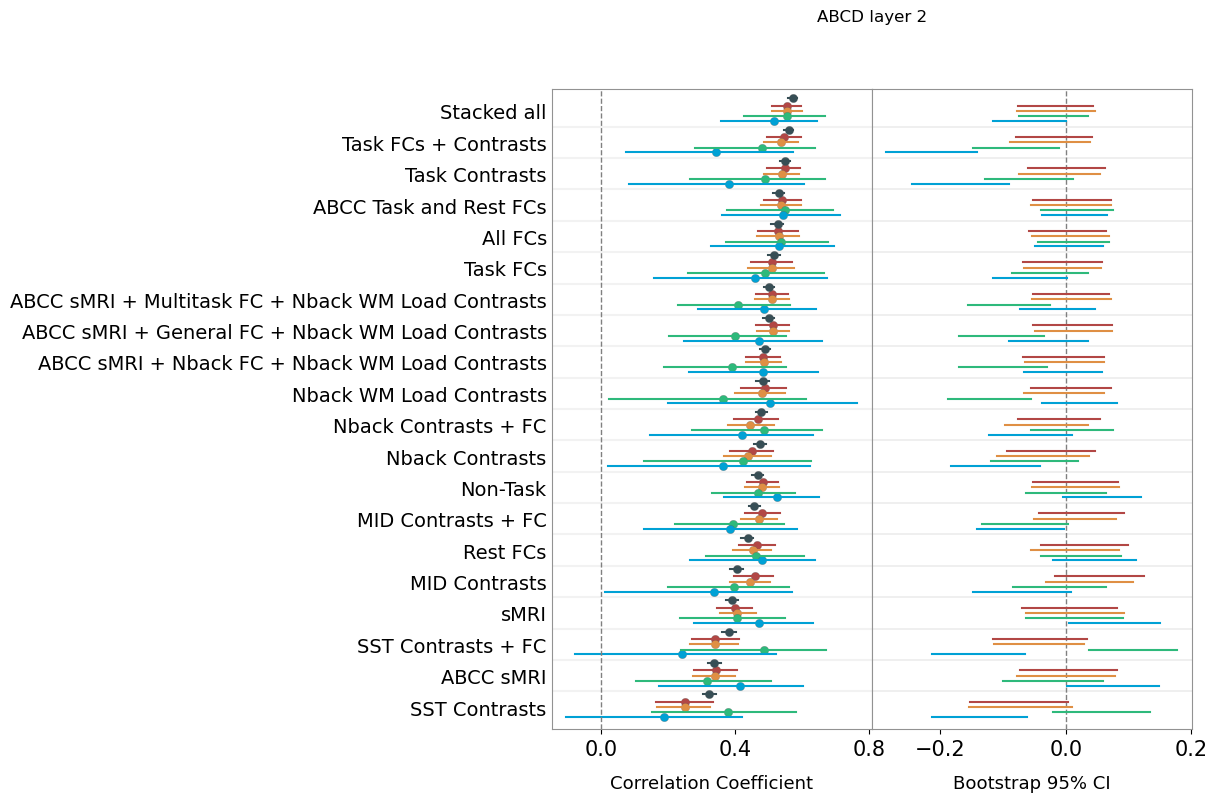

In [ ]:
# dot plot with bars - STACKED
import matplotlib.pyplot as plt
import pandas as pd
import joblib

targ_list = ['total_', 'cryst_', 'fluid_']
targ_names = ['         Total ', 'Crystalised', 'Fluid']
model_list = ['ntrf2']

model = 'ntrf2'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8), sharey=True)
# Define colors for each group
colors = {    'non-ADHD': '#374e55',
    'Tier1': '#b24745',
    'Tier2': '#df8f44',
    'Tier3': '#2eb97b',
    'Tier4': '#00a1d5',
}


# '#374e55', '#b24745', '#df8f44','#2eb97b' , '#00a1d5', 
jitter_offsets = {
    'Tier1': 0.17,
    'Tier2': 0.0,
    'Tier3': -0.17,
    'Tier4': -0.32,
    'non-ADHD': 0.40
}

# ['#b24745', '#df8f44','#79af97' , '#00a1d5', '#374e55', '#c18ea5'] 
title_x = (1.1)/6
for t, targ in enumerate([targ_list[0]]):
    corr_results = joblib.load(plot_dir + targ + model + '_corr_res.joblib')
    # Update corr_results dictionary with meaningful names
    updated_corr_results = {}
    for set_name, features in corr_results.items():
        updated_corr_results[set_name] = {}
        for f_name, data in features.items():
            if f_name in stacked_labels:
                new_name = stacked_labels[f_name]
                updated_corr_results[set_name][new_name] = data

    # Step 1: Extract p_corr values for non-ADHD group across all set names
    non_adhd_p_corr_all = {}
    for set_name in updated_corr_results.keys():
        for f_name in updated_corr_results[set_name].keys():
            if f_name != 'rest':
                non_adhd_p_corr_all[(set_name, f_name)] = updated_corr_results[set_name][f_name]['non-ADHD'][2]

    # Step 2: Sort features by non-ADHD p_corr values
    sorted_features = sorted(non_adhd_p_corr_all.keys(), key=non_adhd_p_corr_all.get, reverse=False)

    # Step 3: Extract and sort p_corr values for all groups based on the sorted features
    groups = ['Tier1', 'Tier2', 'Tier3', 'Tier4', 'non-ADHD']
    group_p_corrs = {group: [updated_corr_results[set_name][f_name][group][2] for set_name, f_name in sorted_features] for group in groups}
    group_cis = {group: [updated_corr_results[set_name][f_name][group][-1] for set_name, f_name in sorted_features] for group in groups}


    # Step 4: Create a single plot with all groups


    # Custom y-axis labels
    feature_labels = [f'{f_name}' for set_name, f_name in sorted_features]
    y_pos = np.arange(len(sorted_features))
    # Add faded horizontal lines between y-ticks
    for y in y_pos:
        if y != y_pos[-1]:
            axes[t*2].axhline(y=y+ 0.5, color='gray', linestyle='-', alpha=0.1)  # Adjust alpha for fading
            pos = axes[t*2].get_position()  # Get the current position
            axes[t*2].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.5]) 
    for group in groups:
        p_corrs = group_p_corrs[group]
        cis = group_cis[group]
        lower_bounds = [ci[0] for ci in cis]
        upper_bounds = [ci[1] for ci in cis]
        
        # Add jitter to the y positions
        jitter = jitter_offsets[group]#np.random.normal(0, 0.1, size=len(y_pos))

        # Plot dots with jittered y positions
        axes[t*2].scatter(p_corrs, y_pos + jitter, color=colors[group], label=group, edgecolor='#5c5b5b', linewidths=0.2)
        
        # Plot confidence intervals as lines with jittered y positions
        for y, lower, upper in zip(y_pos + jitter, lower_bounds, upper_bounds):
            axes[t*2].plot([lower, upper], [y, y], color=colors[group])

    # Custom labels for y-axis ticks
    axes[t*2].set_yticks(y_pos)
    axes[t*2].set_yticklabels(feature_labels, fontsize=16)
    axes[t*2].set_xlabel('Correlation Coefficient', fontsize=13, labelpad=11)#, fontweight='bold'
    # Add legend in the top-right corner
    axes[t*2].axvline(x=0, color='Grey', linestyle='--', linewidth=1)
    axes[t*2+1].axvline(x=0, color='Grey', linestyle='--', linewidth=1)
    y_min, y_max = min(y_pos), max(y_pos)
    axes[t*2].set_ylim(y_min - 0.7, y_max + 0.7)
    axes[t*2+1].set_ylim(y_min - 0.7, y_max + 0.7)
### boot
    boot_results = joblib.load(plot_dir + targ + model + '_boot_res.joblib')
    # Initialize the updated_boot_results dictionary
    updated_boot_results = {}
    # Iterate over the boot_results to update with meaningful names
    for measure, group_data in boot_results.items():
        updated_boot_results[measure] = {}
        for group_name, features in group_data.items():
            updated_boot_results[measure][group_name] = {}
            for f_name, data in features.items():
                if f_name in stacked_labels:
                    new_name = stacked_labels[f_name]
                    updated_boot_results[measure][group_name][new_name] = data

    # bootstrap_cis = {group: [updated_boot_results['pr'][group][f_name][-1] for group in groups[0:4]] for set_name, f_name in sorted_features }
    # Plot the bootstrap confidence intervals in the second subplot
    for group in groups[0:4]:

        # print(group)
        # Plot intervals with jittered y positions
        for y in y_pos:
            # print(sorted_features[y])
            cis = updated_boot_results['pr'][group][sorted_features[y][1]][-1]
            lower_bound = cis[0]
            upper_bound = cis[1]
            jitter = jitter_offsets[group]
            # print(lower_bounds, upper_bounds,jitter )
            axes[t*2+1].plot([lower_bound, upper_bound], [y + jitter, y + jitter], color=colors[group])
            if y != y_pos[-1]:
                axes[t*2+1].axhline(y=y+ 0.5, color='gray', linestyle='-', alpha=0.03)  # Adjust alpha for fading
                pos = axes[t*2+1].get_position()  # Get the current position
                axes[t*2+1].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.5]) 

    # axes[t*2+1].set_yticks(y_pos)
    # axes[t*2+1].set_yticklabels([])  # Remove labels to avoid redundancy
    axes[t*2+1].set_xlabel('Bootstrap 95% CI', fontsize=13, labelpad=11)
    # Draw a vertical line at zero in the second subplot
    
    # ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=12, framealpha=0.1)
    # Add the label above the plots

    # fig.text(title_x + t/3.5 , 0.91, targ_names[t], ha='left', va='bottom', fontsize=12, fontweight='bold')

# Set light grey borders for each subplot
for ax in axes.flat:
    ax.tick_params(axis='x', which='major', labelsize=15)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=14)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    for spine in ax.spines.values():
        spine.set_edgecolor('#929292')  # Light grey color for the borders
    ax.tick_params(axis='y', which='both', length=0)

# Adjust the legend
legend_order = ['non-ADHD', 'Tier1', 'Tier2', 'Tier3', 'Tier4']
handles, labels = axes[0].get_legend_handles_labels()  # Get existing legend items
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: legend_order.index(x[1]))  # Sort based on custom order
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
sorted_labels = ['non-ADHD'] + [f'ADHD-{g}' for g in sorted_labels[1:]]
# axes[0].legend(sorted_handles, sorted_labels, loc='upper right', bbox_to_anchor=(-1, 1.1), 
#                fontsize=14, framealpha=0.3, markerscale=1.5, scatterpoints=1, facecolor='white')

# axes[0].legend(loc='upper right', bbox_to_anchor=(-1, 1.1), fontsize=14, framealpha=0.3, markerscale=1.5, scatterpoints=1, facecolor='white')# Adjust the layout
plt.tight_layout()
# Show the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.00)  # Adjust bottom parameter to reduce space
fig.figure.suptitle("ABCD layer 2", y=1)
# Save the plot (if needed)
# plt.savefig('/home/farzane/Desktop/plots & figures/total_dot_corrgroups.png')
# plt.savefig('/home/farzane/Desktop/Dot - ABCD - Fluid.svg', format='svg', dpi=300, bbox_inches='tight', pad_inches=0.1)#

plt.show()



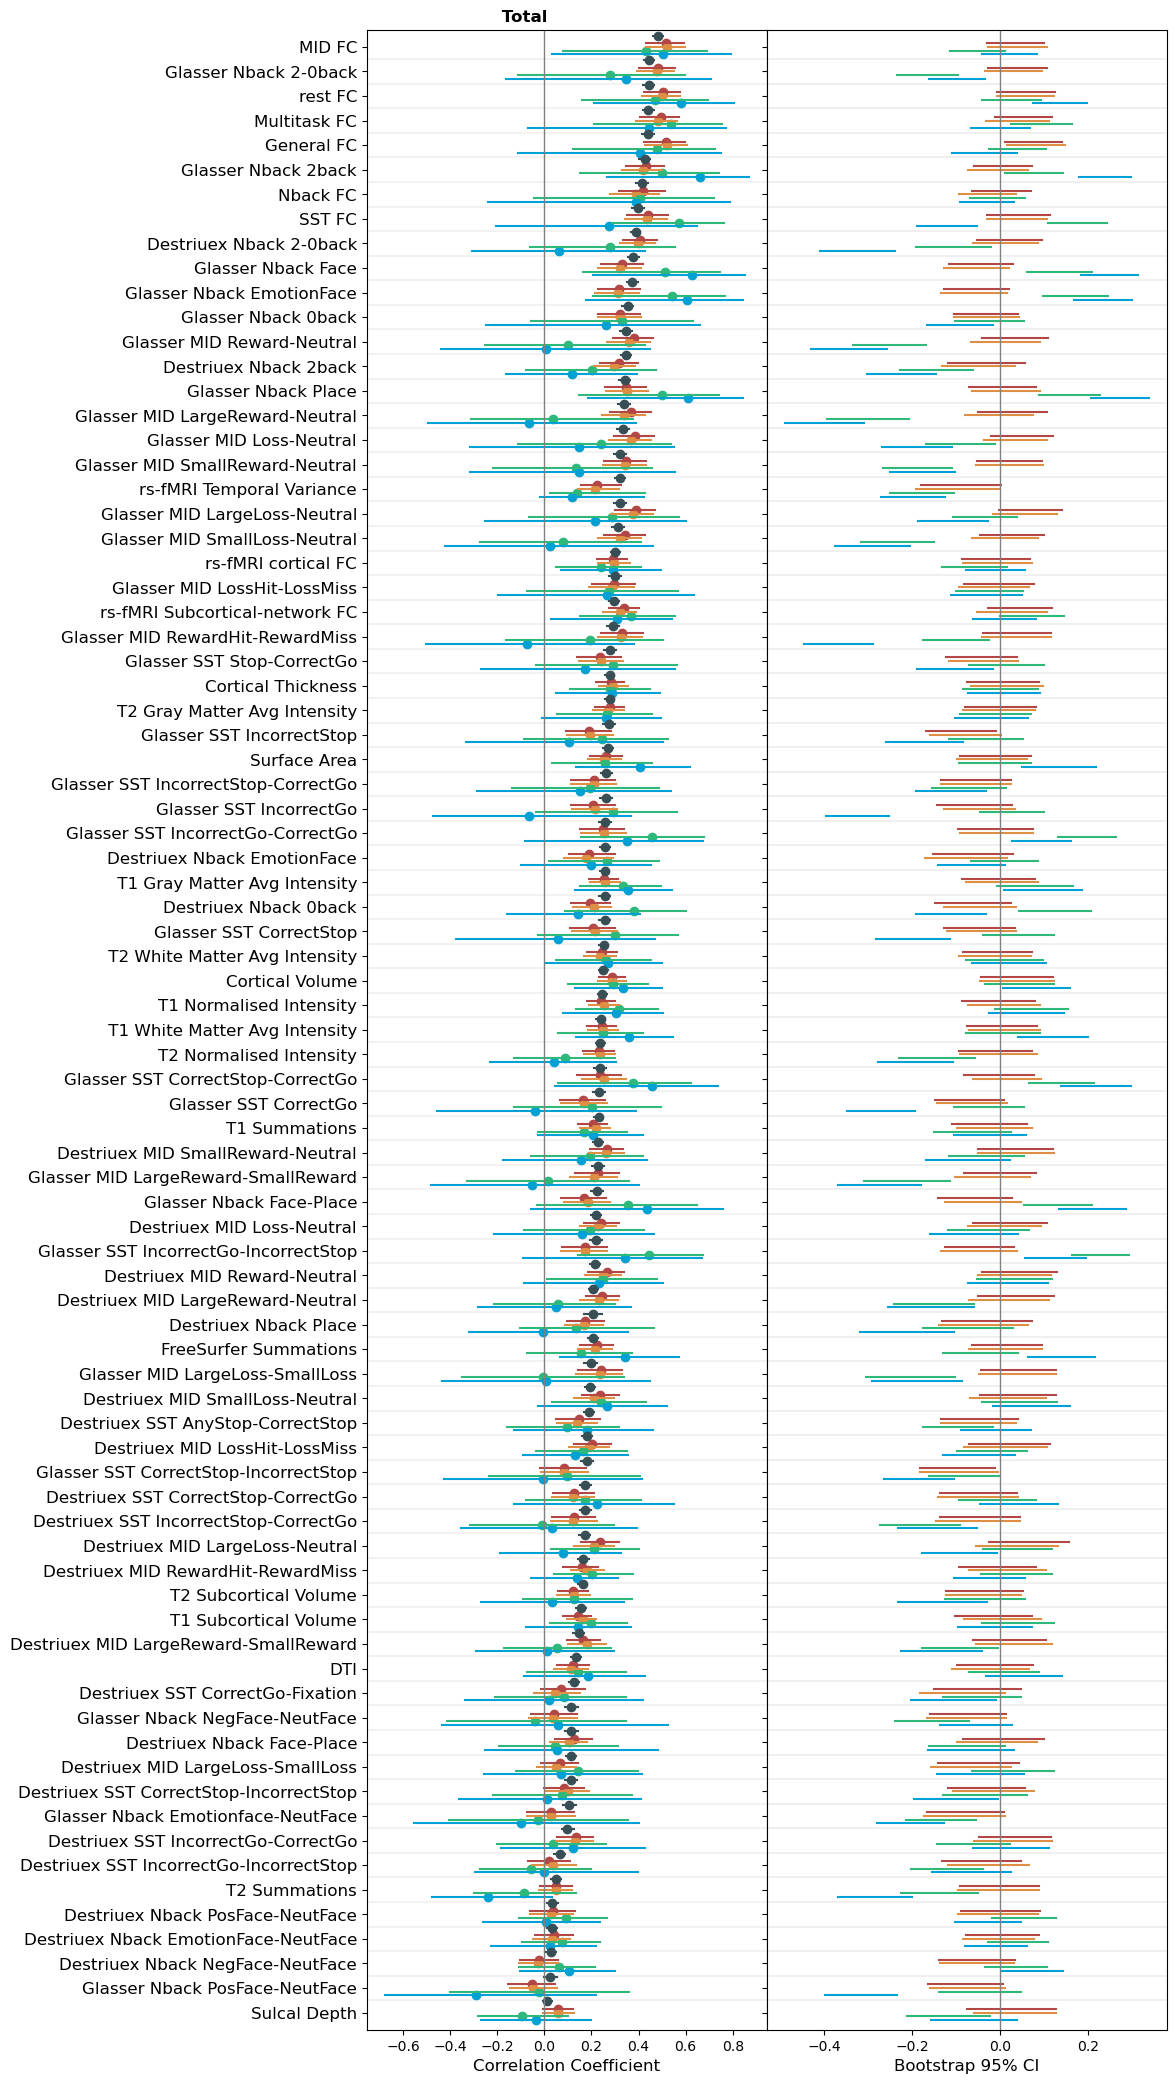

In [ ]:
# dot plot with bars - SINGLE
import matplotlib.pyplot as plt
import pandas as pd
import joblib

targ_list = ['total_']#, 'cryst_', 'fluid_'
targ_names = ['         Total ', 'Crystalised', 'Fluid']
model_list = ['eN1']

model = 'eN1'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 25), sharey=True)
# Define colors for each group
colors = {    'non-ADHD': '#374e55',
    'Tier1': '#b24745',
    'Tier2': '#df8f44',
    'Tier3': '#2eb97b',
    'Tier4': '#00a1d5',
}
jitter_offsets = {
    'Tier1': 0.15,
    'Tier2': 0.0,
    'Tier3': -0.15,
    'Tier4': -0.30,
    'non-ADHD': 0.45
}

title_x = (1.1)/6
for t, targ in enumerate([targ_list[0]]):
    corr_results1 = joblib.load(plot_dir + targ + model + '_corr_res.joblib')
    corr_results2 = joblib.load(plot_dir + targ + model + '_abcd_corr_res.joblib')
    corr_results4 = joblib.load(plot_dir + targ + 'mnct_enet1' + '_corr_res.joblib')
    mnct_dict = {'mnct' : corr_results4.pop('cntr')}
    corr_results = {**corr_results1, **corr_results2, **mnct_dict}
    
    # corr_results = {**corr_results1, **corr_results2}
    # Update corr_results dictionary with meaningful names
    updated_corr_results = {}
    for set_name, features in corr_results.items():
        updated_corr_results[set_name] = {}
        for f_name, data in features.items():
            if f_name in l1_labels:
                new_name = l1_labels[f_name]
                updated_corr_results[set_name][new_name] = data

    # Step 1: Extract p_corr values for non-ADHD group across all set names
    non_adhd_p_corr_all = {}
    for set_name in updated_corr_results.keys():
        for f_name in updated_corr_results[set_name].keys():
            if f_name != 'rest':
                non_adhd_p_corr_all[(set_name, f_name)] = updated_corr_results[set_name][f_name]['non-ADHD'][2]

    # Step 2: Sort features by non-ADHD p_corr values
    sorted_features = sorted(non_adhd_p_corr_all.keys(), key=non_adhd_p_corr_all.get, reverse=False)
    sorted_features = sorted_features[:]
    # Step 3: Extract and sort p_corr values for all groups based on the sorted features
    groups = ['Tier1', 'Tier2', 'Tier3', 'Tier4', 'non-ADHD']
    group_p_corrs = {group: [updated_corr_results[set_name][f_name][group][2] for set_name, f_name in sorted_features] for group in groups}
    group_cis = {group: [updated_corr_results[set_name][f_name][group][-1] for set_name, f_name in sorted_features] for group in groups}

    # Step 4: Create a single plot with all groups
    # Custom y-axis labels
    feature_labels = [f'{f_name}' for set_name, f_name in sorted_features]
    y_pos = np.arange(len(sorted_features))
    # Add faded horizontal lines between y-ticks
    for y in y_pos:
        if y != y_pos[-1]:
            axes[t*2].axhline(y=y+ 0.5, color='gray', linestyle='-', alpha=0.1)  # Adjust alpha for fading
            # pos = axes[t*2].get_position()  # Get the current position
            # axes[t*2].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.5]) 
    for group in groups:
        p_corrs = group_p_corrs[group]
        cis = group_cis[group]
        lower_bounds = [ci[0] for ci in cis]
        upper_bounds = [ci[1] for ci in cis]
        
        # Add jitter to the y positions
        jitter = jitter_offsets[group]#np.random.normal(0, 0.1, size=len(y_pos))

        # Plot dots with jittered y positions
        axes[t*2].scatter(p_corrs, y_pos + jitter, color=colors[group], label=group)
        
        # Plot confidence intervals as lines with jittered y positions
        for y, lower, upper in zip(y_pos + jitter, lower_bounds, upper_bounds):
            axes[t*2].plot([lower, upper], [y, y], color=colors[group])

    # Custom labels for y-axis ticks
    axes[t*2].set_yticks(y_pos)
    axes[t*2].set_yticklabels(feature_labels, fontsize=12)
    axes[t*2].set_xlabel('Correlation Coefficient', fontsize=12)#, fontweight='bold'
    # Add legend in the top-right corner
    # axes[t*2].axvline(x=0, color='Grey', linestyle='-', linewidth=1)
    axes[t*2].axvline(x=0, color='grey', linestyle='-', linewidth=1)
    y_min, y_max = min(y_pos), max(y_pos)
    axes[t*2].set_ylim(y_min - 0.7, y_max + 0.7)
    axes[t*2+1].set_ylim(y_min - 0.7, y_max + 0.7)
### boot - load all model outputs 
    boot_results1 = joblib.load(plot_dir + targ + model + '_boot_res.joblib')
    boot_results3 = joblib.load(plot_dir + targ + model + '_abcd_boot_res.joblib')
    boot_results2 = joblib.load(plot_dir + targ + 'mnct_enet1' + '_boot_res.joblib')
    boot_results_list = [boot_results1, boot_results2, boot_results3]
    # Initialize the updated_boot_results dictionary
    updated_boot_results1 = {}
    updated_boot_results2 = {}
    updated_boot_results3 = {}
 
# Iterate over the boot_results to update with meaningful names
    for measure, group_data in boot_results1.items():
        updated_boot_results1[measure] = {}
        for group_name, features in group_data.items():
            updated_boot_results1[measure][group_name] = {}
            for f_name, data in features.items():
                if f_name in l1_labels:
                    new_name = l1_labels[f_name]
                    updated_boot_results1[measure][group_name][new_name] = data
            for f_name, data in boot_results2[measure][group_name].items():
                if f_name in l1_labels:
                    new_name = l1_labels[f_name]
                    updated_boot_results1[measure][group_name][new_name] = data
            for f_name, data in boot_results3[measure][group_name].items():
                if f_name in l1_labels:
                    new_name = l1_labels[f_name]
                    updated_boot_results1[measure][group_name][new_name] = data            


    # bootstrap_cis = {group: [updated_boot_results['pr'][group][f_name][-1] for group in groups[0:4]] for set_name, f_name in sorted_features }
    # Plot the bootstrap confidence intervals in the second subplot
    for group in groups[0:4]:

        # print(group)
        # Plot intervals with jittered y positions
        for y in y_pos:
            cis = updated_boot_results1['pr'][group][sorted_features[y][1]][-1]
            # print(cis)
            lower_bound = cis[0]
            upper_bound = cis[1]
            jitter = jitter_offsets[group]
            # print(y + jitter)
            # print(lower_bounds, upper_bounds,jitter)
            axes[t*2+1].plot([lower_bound, upper_bound], [y + jitter, y + jitter], color=colors[group])
            if y != y_pos[-1]:
                axes[t*2+1].axhline(y=y+ 0.5, color='gray', linestyle='-', alpha=0.03)  # Adjust alpha for fading
            #     pos = axes[t*2+1].get_position()  # Get the current position
            #     axes[t*2+1].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.5]) 

    # ax2.set_yticks(y_pos)
    # ax2.set_yticklabels([])  # Remove labels to avoid redundancy
    axes[t*2+1].set_xlabel('Bootstrap 95% CI', fontsize=12)
    # Draw a vertical line at zero in the second subplot
    axes[t*2+1].axvline(x=0, color='Grey', linestyle='-', linewidth=1)
    # ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=12, framealpha=0.1)
    # Add the label above the plots

    fig.text(title_x + t/3.5 , 0.902, targ_names[t], ha='left', va='bottom', fontsize=12, fontweight='bold')
    

# axes[4].legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=12, framealpha=0.1)
# Adjust the layout
plt.tight_layout()
# Show the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.00)  # Adjust bottom parameter to reduce space, hspace=5
# fig.figure.suptitle("ABCD layer 1", y=1)
# Save the plot (if needed)
# plt.savefig('/home/farzane/Desktop/plots & figures/total_dot_corrgroups.png')
plt.show()




## Lytle

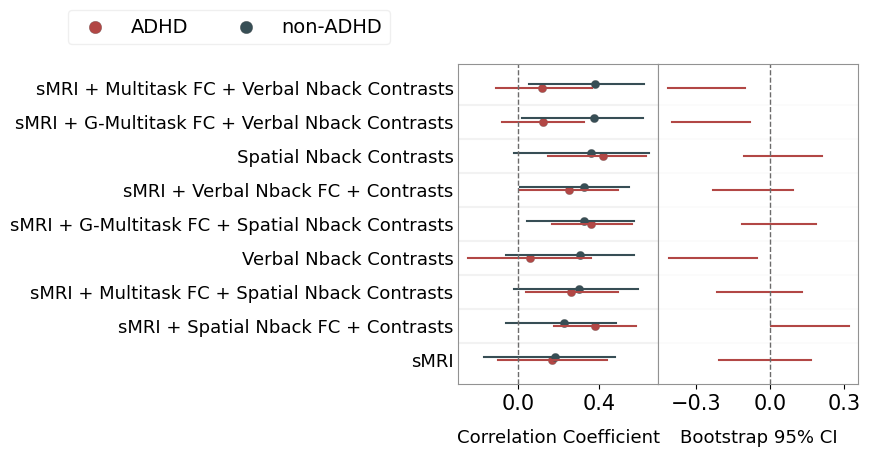

In [ ]:
# op1 dot plot with bars - STACKED
import matplotlib.pyplot as plt
import joblib


op1stacked_labels =  {

    'All8_v' : 'sMRI + Multitask FC + Verbal Nback Contrasts',
    'All9_v' : 'sMRI + G-Multitask FC + Verbal Nback Contrasts',
    'All10_v' : 'sMRI + Verbal Nback FC + Contrasts',
    'All8_s' : 'sMRI + Multitask FC + Spatial Nback Contrasts',
    'All9_s' : 'sMRI + G-Multitask FC + Spatial Nback Contrasts',
    'All10_s' : 'sMRI + Spatial Nback FC + Contrasts',
    'Str2' : 'sMRI',
    'WmCntr2_v' : 'Verbal Nback Contrasts',
    'WmCntr2_s' : 'Spatial Nback Contrasts',
}

# targ = 'FSIQ_'
model = 'rf2_output_fstd'
targ_list = ['FSIQ_', 'PIQ_', 'VIQ_']
test_set = '_op1' #'op2_'
model_list = ['rf2_output_fstd']#

# Define colors for each group
colors = {    'non-ADHD': '#374e55',
    'ADHD': '#b24745',
}
jitter_offsets = {
    'ADHD': 0.0,
    'non-ADHD': 0.1
}
title_x = (1.1)/6
#Create a single plot with all groups
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 4), sharey=True)

for t, targ in enumerate([targ_list[0]]):
    corr_results = joblib.load(plot_dir + targ + model + test_set + '_corr_res.joblib')
    # Update corr_results dictionary with meaningful names
    updated_corr_results = {}
    for set_name, features in corr_results.items():
        updated_corr_results[set_name] = {}
        for f_name, data in features.items():
            if f_name in op1stacked_labels:
                new_name = op1stacked_labels[f_name]
                updated_corr_results[set_name][new_name] = data

    # Step 1: Extract p_corr values for non-ADHD group across all set names
    non_adhd_p_corr_all = {}
    for set_name in updated_corr_results.keys():
        for f_name in updated_corr_results[set_name].keys():
            if f_name != 'rest':
                non_adhd_p_corr_all[(set_name, f_name)] = updated_corr_results[set_name][f_name]['non-ADHD'][2]

    # Step 2: Sort features by non-ADHD p_corr values
    sorted_features = sorted(non_adhd_p_corr_all.keys(), key=non_adhd_p_corr_all.get, reverse=False)

    # Step 3: Extract and sort p_corr values for all groups based on the sorted features
    groups = ['ADHD', 'non-ADHD']
    group_p_corrs = {group: [updated_corr_results[set_name][f_name][group][2] for set_name, f_name in sorted_features] for group in groups}
    group_cis = {group: [updated_corr_results[set_name][f_name][group][-1] for set_name, f_name in sorted_features] for group in groups}

    # Custom y-axis labels
    feature_labels = [f'{f_name}' for set_name, f_name in sorted_features]
    y_pos = np.arange(len(sorted_features))
    # Add faded horizontal lines between y-ticks
    for y in y_pos:
        if y != y_pos[-1]:
            axes[t*2].axhline(y=y+ 0.5, color='gray', linestyle='-', alpha=0.1)  # Adjust alpha for fading
            pos = axes[t*2].get_position()  # Get the current position
            axes[t*2].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.5]) 
    for group in groups:
        p_corrs = group_p_corrs[group]
        cis = group_cis[group]
        lower_bounds = [ci[0] for ci in cis]
        upper_bounds = [ci[1] for ci in cis]
        
        # Add jitter to the y positions
        jitter = jitter_offsets[group]#np.random.normal(0, 0.1, size=len(y_pos))

        # Plot dots with jittered y positions
        axes[t*2].scatter(p_corrs, y_pos + jitter, color=colors[group], label=group, edgecolor='#5c5b5b', linewidths=0.2)
        
        # Plot confidence intervals as lines with jittered y positions
        for y, lower, upper in zip(y_pos + jitter, lower_bounds, upper_bounds):
            axes[t*2].plot([lower, upper], [y, y], color=colors[group])

    # Custom labels for y-axis ticks
    axes[t*2].set_yticks(y_pos)
    axes[t*2].set_yticklabels(feature_labels, fontsize=14)

    # Adjust layout
    axes[t*2].set_xlabel('Correlation Coefficient', fontsize=13, labelpad=11)#, fontweight='bold'
    axes[t*2].axvline(x=0, color='#6c6b6b', linestyle='--', linewidth=1)
    y_min, y_max = min(y_pos), max(y_pos)
    axes[t*2].set_ylim(y_min - 0.7, y_max + 0.7)
    axes[t*2+1].set_ylim(y_min - 0.7, y_max + 0.7)
### boot
    boot_results = joblib.load(plot_dir + targ + model + test_set + '_boot_res.joblib')
    # Initialize the updated_boot_results dictionary
    updated_boot_results = {}
    # Iterate over the boot_results to update with meaningful names
    for measure, group_data in boot_results.items():
        updated_boot_results[measure] = {}
        for group_name, features in group_data.items():
            updated_boot_results[measure][group_name] = {}
            for f_name, data in features.items():
                if f_name in op1stacked_labels:
                    new_name = op1stacked_labels[f_name]
                    updated_boot_results[measure][group_name][new_name] = data

    # Plot the bootstrap confidence intervals in the second subplot
    for group in [groups[0]]:

        # print(group)
        # Plot intervals with jittered y positions
        for y in y_pos:
            # print(sorted_features[y])
            cis = updated_boot_results['pr'][group][sorted_features[y][1]][-1]
            lower_bound = cis[0]
            upper_bound = cis[1]
            jitter = jitter_offsets[group]
            # print(lower_bounds, upper_bounds,jitter )
            axes[t*2+1].plot([lower_bound, upper_bound], [y + jitter, y + jitter], color=colors[group])
            if y != y_pos[-1]:
                axes[t*2+1].axhline(y=y+ 0.5, color='gray', linestyle='-', alpha=0.03)  # Adjust alpha for fading
                pos = axes[t*2+1].get_position()  # Get the current position
                axes[t*2+1].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.5]) 


    axes[t*2+1].set_xlabel('Bootstrap 95% CI', fontsize=13, labelpad=11)
    axes[t*2+1].tick_params(axis='x', which='major', labelsize=15)
    # Draw a vertical line at zero in the second subplot
    axes[t*2+1].axvline(x=0, color='#6c6b6b', linestyle='--', linewidth=1)


# Set light grey borders for each subplot
for ax in axes.flat:

    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=13)
    for spine in ax.spines.values():
        spine.set_edgecolor('#929292')  # Light grey color for the borders
        ax.tick_params(axis='x', which='major', labelsize=15)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.tick_params(axis='y', which='both', length=0)
# axes[0].legend(loc='upper right', bbox_to_anchor=(-1.6, 1), fontsize=12, framealpha=0.1)
# axes[0].legend(loc='upper left', bbox_to_anchor=(-2.2, 1.2), fontsize=14, framealpha=0.3, markerscale=1.5, scatterpoints=1, facecolor='white')# Adjust the layout
legend_order = ['non-ADHD', 'ADHD']
handles, labels = axes[0].get_legend_handles_labels()  # Get existing legend items
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: legend_order.index(x[1]))  # Sort based on custom order
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
axes[0].legend(
    loc='upper left', 
    bbox_to_anchor=(-2.0, 1.2), 
    fontsize=14, 
    framealpha=0.3, 
    markerscale=1.5, 
    scatterpoints=1, 
    facecolor='white',
    ncol=2  # Display legend items in one row
)
# Adjust layout to reduce top space only
 # Reduce top space
# plt.xticks(fontsize=12, )#fontweight='bold'
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.00) 
# fig.figure.suptitle("OP1 layer 2", y=1)
# Save the plot (if needed)
# plt.savefig('/home/farzane/Desktop/plots & figures/total_dot_corrgroups.png')
# plt.savefig('/home/farzane/Desktop/Dot - OP1 - leg.svg', format='svg' ,  dpi=300, bbox_inches='tight', pad_inches=0.1)#format='svg',

plt.show()


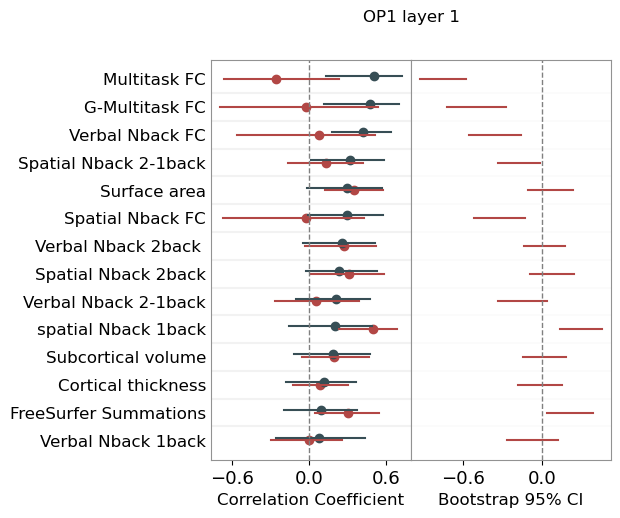

In [ ]:
# dot plot with bars - SINGLE
import matplotlib.pyplot as plt
import pandas as pd
import joblib


op1l1_labels =  {
'cort': 'Cortical thickness',
'surf': 'Surface area',
'subc': 'Subcortical volume',
'VolBrain': 'FreeSurfer Summations',
'verbal': 'Verbal Nback FC',
'spatial' : 'Spatial Nback FC',
'tfc': 'Multitask FC',
'gtfc': 'G-Multitask FC',
'cntr_twoback_task-verbal': 'Verbal Nback 2back ',
'cntr_oneback_task-verbal' : 'Verbal Nback 1back',
'cntr_twoback-oneback_task-verbal' : 'Verbal Nback 2-1back',
'cntr_twoback_task-spatial': 'Spatial Nback 2back',
'cntr_oneback_task-spatial' : 'spatial Nback 1back',
'cntr_twoback-oneback_task-spatial': 'Spatial Nback 2-1back',
}

# targ = 'FSIQ_'
model = 'enet1_output_fstd'
targ_list = ['FSIQ_', 'PIQ_', 'VIQ_']
test_set = '_op1' #'op2_'

# Define colors for each group
colors = {    'non-ADHD': '#374e55',
    'ADHD': '#b24745',
}

jitter_offsets = {
    'ADHD': 0.0,
    'non-ADHD': 0.1
}
title_x = (1.1)/6
#Create a single plot with all groups
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5), sharey=True)

for t, targ in enumerate([targ_list[0]]):
    corr_results = joblib.load(plot_dir + targ + model + test_set +'_corr_res.joblib')
    # Update corr_results dictionary with meaningful names
    updated_corr_results = {}
    for set_name, features in corr_results.items():
        updated_corr_results[set_name] = {}
        for f_name, data in features.items():
            if f_name in op1l1_labels:
                new_name = op1l1_labels[f_name]
                updated_corr_results[set_name][new_name] = data

    # Step 1: Extract p_corr values for non-ADHD group across all set names
    non_adhd_p_corr_all = {}
    for set_name in updated_corr_results.keys():
        for f_name in updated_corr_results[set_name].keys():
            if f_name != 'rest':
                non_adhd_p_corr_all[(set_name, f_name)] = updated_corr_results[set_name][f_name]['non-ADHD'][2]

    # Step 2: Sort features by non-ADHD p_corr values
    sorted_features = sorted(non_adhd_p_corr_all.keys(), key=non_adhd_p_corr_all.get, reverse=False)

    # Step 3: Extract and sort p_corr values for all groups based on the sorted features
    groups = ['ADHD', 'non-ADHD']
    group_p_corrs = {group: [updated_corr_results[set_name][f_name][group][2] for set_name, f_name in sorted_features] for group in groups}
    group_cis = {group: [updated_corr_results[set_name][f_name][group][-1] for set_name, f_name in sorted_features] for group in groups}


    # Step 4: Create a single plot with all groups
    # Custom y-axis labels
    feature_labels = [f'{f_name}' for set_name, f_name in sorted_features]
    y_pos = np.arange(len(sorted_features))
    # Add faded horizontal lines between y-ticks
    for y in y_pos:
        if y != y_pos[-1]:
            axes[t*2].axhline(y=y+ 0.5, color='gray', linestyle='-', alpha=0.1)  # Adjust alpha for fading

    for group in groups:
        p_corrs = group_p_corrs[group]
        cis = group_cis[group]
        lower_bounds = [ci[0] for ci in cis]
        upper_bounds = [ci[1] for ci in cis]
        
        # Add jitter to the y positions
        jitter = jitter_offsets[group]#np.random.normal(0, 0.1, size=len(y_pos))

        # Plot dots with jittered y positions
        axes[t*2].scatter(p_corrs, y_pos + jitter, color=colors[group], label=group)
        
        # Plot confidence intervals as lines with jittered y positions
        for y, lower, upper in zip(y_pos + jitter, lower_bounds, upper_bounds):
            axes[t*2].plot([lower, upper], [y, y], color=colors[group])

    # Custom labels for y-axis ticks
    axes[t*2].set_yticks(y_pos)
    axes[t*2].set_yticklabels(feature_labels, fontsize=12)
    axes[t*2].set_xlabel('Correlation Coefficient', fontsize=12)#, fontweight='bold'
    # Add legend in the top-right corner
    # axes[t*2].axvline(x=0, color='Grey', linestyle='-', linewidth=1)
    axes[t*2].axvline(x=0, color='grey', linestyle='--', linewidth=1)
    y_min, y_max = min(y_pos), max(y_pos)
    axes[t*2].set_ylim(y_min - 0.7, y_max + 0.7)
    axes[t*2+1].set_ylim(y_min - 0.7, y_max + 0.7)
### boot
    boot_results = joblib.load(plot_dir + targ + model + test_set + '_boot_res.joblib')
    # Initialize the updated_boot_results dictionary
    updated_boot_results = {}
    # Iterate over the boot_results to update with meaningful names
    for measure, group_data in boot_results.items():
        updated_boot_results[measure] = {}
        for group_name, features in group_data.items():
            updated_boot_results[measure][group_name] = {}
            for f_name, data in features.items():
                if f_name in op1l1_labels:
                    new_name = op1l1_labels[f_name]
                    updated_boot_results[measure][group_name][new_name] = data

    # Plot the bootstrap confidence intervals in the second subplot
    for group in [groups[0]]:

        # print(group)
        # Plot intervals with jittered y positions
        for y in y_pos:
            cis = updated_boot_results['pr'][group][sorted_features[y][1]][-1]
            # print(cis)
            lower_bound = cis[0]
            upper_bound = cis[1]
            jitter = jitter_offsets[group]
            # print(y + jitter)
            # print(lower_bounds, upper_bounds,jitter)
            axes[t*2+1].plot([lower_bound, upper_bound], [y + jitter, y + jitter], color=colors[group])
            if y != y_pos[-1]:
                axes[t*2+1].axhline(y=y+ 0.5, color='gray', linestyle='-', alpha=0.03)  # Adjust alpha for fading
            #     pos = axes[t*2+1].get_position()  # Get the current position
            #     axes[t*2+1].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.5]) 


    axes[t*2+1].set_xlabel('Bootstrap 95% CI', fontsize=12)
    # Draw a vertical line at zero in the second subplot
    axes[t*2+1].axvline(x=0, color='Grey', linestyle='--', linewidth=1)

    
# Set light grey borders for each subplot
for ax in axes.flat:
    for spine in ax.spines.values():
        spine.set_edgecolor('#929292')  # Light grey color for the borders
# axes[4].legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=12, framealpha=0.1)
        
        # Set light grey borders for each subplot
for ax in axes.flat:
    for spine in ax.spines.values():
        spine.set_edgecolor('#929292')  # Light grey color for the borders
    #plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=13)
    for spine in ax.spines.values():
        spine.set_edgecolor('#929292')  # Light grey color for the borders
        ax.tick_params(axis='x', which='major', labelsize=13)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.tick_params(axis='y', which='both', length=0)
# Adjust the layout
plt.tight_layout()
# Show the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.00)  # Adjust bottom parameter to reduce space, hspace=5
fig.figure.suptitle("OP1 layer 1", y=1)
# Save the plot (if needed)
# plt.savefig('/home/farzane/Desktop/plots & figures/total_dot_corrgroups.png')
plt.show()




## 3. Ridge plot 
### distribution of predicited and observed scores across groups

## ABCD

In [ ]:
# test statistical difference between observed and predicted (best stacked model)
import pandas as pd
from scipy.stats import ttest_ind
import joblib
import numpy as np
from typing import Dict, Any
from scipy.stats.mstats import winsorize
from scipy.stats import bootstrap

def my_statistic(sample1, sample2):
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    return mean1 - mean2
def abcd_calculate_stats(test_columns):


    # Assuming your dataframe is named df
    # Group names
    groups = ['ADHD-Tier 1', 'ADHD-Tier 2', 'ADHD-Tier 3', 'ADHD-Tier 4', 'Non-ADHD']



    # Initialize a dictionary to collect t-test results
    ttest_results = {}

    # Perform t-test for each column between Non-ADHD and each ADHD tier group
    for column in test_columns:
        ttest_results[column] = {}
        for tier in groups[:-1]:  # Exclude Non-ADHD for inner loop
            # Filter data for Non-ADHD and current tier
            non_adhd_data = best_model_vals_glong[best_model_vals_glong['Group'] == 'Non-ADHD'][column].dropna()
            tier_data = best_model_vals_glong[best_model_vals_glong['Group'] == tier][column].dropna()
            # print(best_model_vals_glong[best_model_vals_glong['Group'] == tier][column])
            # Calculate sample sizes
            n1 = len(non_adhd_data)
            n2 = len(tier_data)
            # Perform t-test
            mean1 = np.mean(non_adhd_data)
            mean2 = np.mean(tier_data)
            sd1 = np.std(non_adhd_data)
            sd2 = np.std(tier_data)
            t_stat, p_val = ttest_ind(non_adhd_data, tier_data, equal_var=False)  # Welch's t-test
            if p_val < 0.0001 :
                spval = '****'
            elif p_val < 0.001 :
                spval = '***'
            elif p_val < 0.01 :
                spval = '**'
            elif p_val < 0.05:
                spval = '*'
            else:
                spval = ''


            # Calculate sample variances
            s1_squared = np.var(non_adhd_data, ddof=1)  # Variance with Bessel's correction
            s2_squared = np.var(tier_data, ddof=1)      # Variance with Bessel's correction

            # Calculate Welch-Satterthwaite degrees of freedom
            df = ((s1_squared / n1) + (s2_squared / n2))**2 / (((s1_squared / n1)**2 / (n1 - 1)) + ((s2_squared / n2)**2 / (n2 - 1)))

  
            # print(n1, n2 ,  tier , f"Degrees of freedom: {df:.2f}")

            glass_d = (mean2 - mean1) / sd1

            # Calculate standard deviations
            sd1c = np.std(non_adhd_data, ddof=1)
            sd2c = np.std(tier_data, ddof=1)



            # Calculate pooled standard deviation
            sd_pooled = np.sqrt(((n1 - 1) * sd1c**2 + (n2 - 1) * sd2c**2) / (n1 + n2 - 2))

            # Calculate Cohen's d
            cohen_d = (mean1 - mean2) / sd_pooled

            # Calculate correction factor for Hedges' g
            correction_factor = 1 - (3 / (4 * (n1 + n2 - 2) - 1))
            
            # Calculate Hedges' g
            hedges_g = cohen_d * correction_factor


            data = (non_adhd_data, tier_data)

            res = bootstrap(data, my_statistic, method='basic')
            # print('bootsrap mean' , tier, column)
            # print(my_statistic(non_adhd_data, tier_data))
            # print(res.confidence_interval)

            confidence_interval_mean = res.confidence_interval
            mean_comp = ('*' if confidence_interval_mean[0] > 0 and confidence_interval_mean[1] > 0 else
                        '*' if confidence_interval_mean[0] < 0 and confidence_interval_mean[1] < 0 else '')


            # Store the results
            ttest_results[column][tier] = {'n1':n1, 'n2':n2, 't_stat': t_stat, 'p_val': spval, 'non_mean': mean1, 'adhd_mean': mean2, 'non_sd': sd1, 'adhd_sd': sd2, 'Glass Δ' : glass_d, 'cohen_d': cohen_d, 'hedges g': hedges_g , 'df': df ,'boot_mean' : mean_comp, 'boot_conf' : confidence_interval_mean}
            
            # print(column, tier, p_val)
    # # Print the results
    # for column in ttest_results:
    #     print(f"T-test results for {column}:")
    #     for tier, results in ttest_results[column].items():
    #         print(f"  Non-ADHD ({results['non_mean']:.4f}, {results['non_sd']:.4f}) vs {tier} ({results['adhd_mean']:.4f}, {results['adhd_sd']:.4f}): t-statistic = {results['t_stat']:.4f}, p-value = {results['p_val']:.4f}, glass = {results['Glass Δ']:.4f}")
    #     print("\n")
    return ttest_results


In [ ]:
# prepare data for plotting
# targ = 'total_'
model = 'ntrf2'
tvals = joblib.load(plot_dir  + 'total_' + model + '_corr_res.joblib')
cvals = joblib.load(plot_dir  + 'cryst_' + model + '_corr_res.joblib')
fvals = joblib.load(plot_dir  + 'fluid_' + model + '_corr_res.joblib')
# best_model_tvals =  pd.concat([tvals['stacked']['All1_abcd']['All'][-2][1], tvals['stacked']['All1_abcd']['All'][-2][0]], axis=1)
best_model_tvals =  pd.concat([tvals['stacked']['All1_abcd']['All'][-2][1], All.iloc[:,2]], axis=1)
best_model_tvals.columns =  ['pred','true']
# best_model_cvals =  pd.concat([cvals['stacked']['All1_abcd']['All'][-2][1], cvals['stacked']['All1_abcd']['All'][-2][0]], axis=1)
best_model_cvals =  pd.concat([cvals['stacked']['All1_abcd']['All'][-2][1], All.iloc[:,1]], axis=1)

best_model_cvals.columns =  ['pred','true']
# best_model_fvals = pd.concat([fvals['stacked']['All1_abcd']['All'][-2][1], fvals['stacked']['All1_abcd']['All'][-2][0]], axis=1)
best_model_fvals = pd.concat([fvals['stacked']['All1_abcd']['All'][-2][1], All.iloc[:,0]], axis=1)

best_model_fvals.columns =  ['pred','true']
# Concatenate the DataFrames along the columns axis
best_model_vals = pd.concat([best_model_tvals, best_model_cvals, best_model_fvals], axis=1)
keys = ['{}_{}'.format(key, col) for key in ['tvals', 'cvals', 'fvals'] for col in ['pred', 'true']]

# Set new keys to the columns of the merged DataFrame
best_model_vals.columns = keys
# print(best_model_vals.shape)#

# best_model_vals = best_model_vals.loc[:, ~best_model_vals.columns.duplicated()]
group_indices = {
    'ADHD-Tier 1': list(T1.index),
    'ADHD-Tier 2': list(T2.index),
    'ADHD-Tier 3': list(T3.index),
    'ADHD-Tier 4': list(T4.index),
    'Non-ADHD': list(non.index)
}

best_model_vals['ADHD-Tier 1'] = ''
f_ind = list(set(best_model_vals.index).intersection(set(list(T1.index))))
best_model_vals.loc[f_ind, 'ADHD-Tier 1'] = 'ADHD-Tier 1'

best_model_vals['ADHD-Tier 2'] = ''
f_ind = list(set(best_model_vals.index).intersection(set(list(T2.index))))
best_model_vals.loc[f_ind, 'ADHD-Tier 2'] = 'ADHD-Tier 2'

best_model_vals['ADHD-Tier 3'] = ''
f_ind = list(set(best_model_vals.index).intersection(set(list(T3.index))))
best_model_vals.loc[f_ind, 'ADHD-Tier 3'] = 'ADHD-Tier 3'

best_model_vals['ADHD-Tier 4'] = ''
f_ind = list(set(best_model_vals.index).intersection(set(list(T4.index))))
best_model_vals.loc[f_ind, 'ADHD-Tier 4'] = 'ADHD-Tier 4'

best_model_vals['Non-ADHD'] = ''
f_ind = list(set(best_model_vals.index).intersection(set(list(non.index))))
best_model_vals.loc[f_ind, 'Non-ADHD'] = 'Non-ADHD'
# print(best_model_vals)
# print(best_model_vals[best_model_vals['ADHD-Tier 1'] == 'ADHD-Tier 1'].shape)
best_model_vals = best_model_vals.reset_index()
# Convert to long format
best_model_vals_glong = best_model_vals.melt(id_vars=['src_subject_id', 'tvals_pred', 'tvals_true', 'cvals_pred', 'cvals_true', 'fvals_pred', 'fvals_true'], 
                                             value_vars=['ADHD-Tier 1', 'ADHD-Tier 2', 'ADHD-Tier 3', 'ADHD-Tier 4', 'Non-ADHD'], var_name='Grouping', value_name= 'Group')

# Remove rows where 'Group' is NaN
best_model_vals_long = best_model_vals_glong.dropna(subset=['Group'])

# Optional: Reset index if needed
best_model_vals_long = best_model_vals_long.reset_index(drop=True)
# print(best_model_vals_glong)

# best_model_vals.columns =  ['pred','true','Group']
best_model_valst = best_model_vals_glong.drop(columns=['tvals_pred', 'cvals_pred', 'fvals_pred', 'Grouping'])
best_model_valsp = best_model_vals_glong.drop(columns=['tvals_true', 'cvals_true','fvals_true', 'Grouping' ])


# Convert to long format
pred_true_long = best_model_valst.melt(id_vars=['src_subject_id', 'Group'], value_vars=['tvals_true', 'cvals_true', 'fvals_true'],
                                var_name='Type', value_name='Score')

# Convert to long format
pred_pred_long = best_model_valsp.melt(id_vars=['src_subject_id', 'Group'], value_vars=['tvals_pred', 'cvals_pred', 'fvals_pred'],
                                var_name='Type', value_name='Score')

pred_true_long.rename(columns={'src_subject_id': 'Original_Index'}, inplace=True)
pred_pred_long.rename(columns={'src_subject_id': 'Original_Index'}, inplace=True)

pred_true_long.index = pred_true_long['Original_Index']
pred_true_long = pred_true_long.drop(columns=['Original_Index'])

pred_pred_long.index = pred_pred_long['Original_Index']
pred_pred_long = pred_pred_long.drop(columns=['Original_Index'])


# Create a new DataFrame with combined 'Type' and 'Group'
pred_true_combined = pred_true_long.copy()
pred_true_combined['Type_Group'] = pred_true_combined['Type'] + '_' + pred_true_combined['Group'].astype(str)
# drop the original 'Type' and 'Group' columns 
pred_true_combined = pred_true_combined.drop(columns=['Type', 'Group'])



# Create a new DataFrame with combined 'Type' and 'Group'
pred_pred_combined = pred_pred_long.copy()
pred_pred_combined['Type_Group'] = pred_pred_combined['Type'] + '_' + pred_pred_combined['Group'].astype(str)
# Create a new DataFrame with combined 'Type' and 'Group'
pred_pred_combined = pred_pred_long.copy()
pred_pred_combined['Type_Group'] = pred_pred_combined['Type'] + '_' + pred_pred_combined['Group'].astype(str)
# drop the original 'Type' and 'Group' columns 
pred_pred_combined = pred_pred_combined.drop(columns=['Type', 'Group'])


/tmp/ipykernel_293957/4289878933.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_true_combined_total['Type_Group'] = pred_true_combined_total['Type_Group'].cat.remove_unused_categories()
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True)

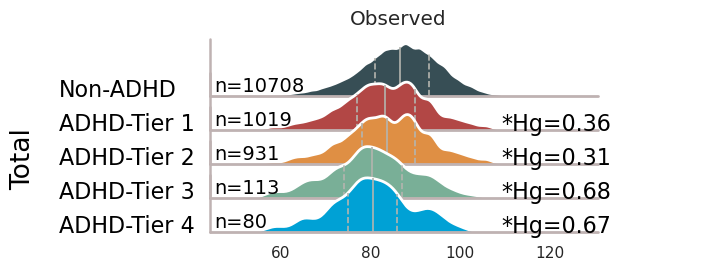

In [ ]:
# plot true ridge ABCD
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Columns to test
test_columns = ['tvals_true', 'cvals_true', 'fvals_true']
# Add dummy entries for empty rows
empty_rows = ['empty1', 'empty2']
empty_entries = pd.DataFrame({'Score': [np.nan] * 2, 'Type_Group': empty_rows})
pred_true_combined_with_empty = pd.concat([pred_true_combined, empty_entries], ignore_index=True)

# color_list = ['#88bca0', '#ffb1c3', '#ec8597', '#bc5a6d', '#8e3047', '#fbfbfb', '#88bca0', '#ff9ddb', '#ffa27c', '#ff7070', '#c83e3a', '#fbfbfb', '#79af97', '#374e55', '#00a1d5', '#b24745', '#df8f44', '#fbfbfb']

color_list = ['#374e55', '#b24745', '#df8f44','#79af97' , '#00a1d5',  '#fbfbfb', '#374e55', '#b24745', '#df8f44','#79af97' , '#00a1d5','#fbfbfb', '#374e55', '#b24745', '#df8f44','#79af97' , '#00a1d5']

# Create a list of unique labels from Type_Group
unique_labels = ['tvals_true_Non-ADHD', 'tvals_true_ADHD-Tier 1',
       'tvals_true_ADHD-Tier 2', 'tvals_true_ADHD-Tier 3',
       'tvals_true_ADHD-Tier 4', 'cvals_true_Non-ADHD',
       'cvals_true_ADHD-Tier 1', 'cvals_true_ADHD-Tier 2',
       'cvals_true_ADHD-Tier 3', 'cvals_true_ADHD-Tier 4',
       'fvals_true_Non-ADHD', 'fvals_true_ADHD-Tier 1',
       'fvals_true_ADHD-Tier 2', 'fvals_true_ADHD-Tier 3',
       'fvals_true_ADHD-Tier 4']
c_labels = ['', '',
       'Total', '',
       '', '',
       '', '',
       'Crystalized', '',
       '', '',
       '', '',
       'Fluid']
# Insert empty rows at specific positions
insert_positions = [5, 11]  # Insert after the 5th and 10th rows
for pos, empty_row in zip(insert_positions, empty_rows):
    unique_labels.insert(pos, empty_row)

# Reorder the DataFrame based on the new label order
pred_true_combined_with_empty['Type_Group'] = pd.Categorical(pred_true_combined_with_empty['Type_Group'], categories=unique_labels, ordered=True)
pred_true_combined_with_empty = pred_true_combined_with_empty.sort_values('Type_Group')
pred_true_combined_total = pred_true_combined_with_empty
pred_true_combined_total = pred_true_combined_with_empty[pred_true_combined_with_empty['Type_Group'].isin(unique_labels[0:5])]
pred_true_combined_total['Type_Group'] = pred_true_combined_total['Type_Group'].cat.remove_unused_categories()
# Plotting
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(5, start=2, rot=0, light=.7, dark=.3, reverse=False)
xlim = (pred_true_combined['Score'].min() + 0.30, pred_true_combined['Score'].max() - 0.3)

# Plot each score type using FacetGrid
g = sns.FacetGrid(pred_true_combined_total, row="Type_Group", aspect=10, height=.5, palette=pal, sharex=True, sharey=True)
g.map_dataframe(sns.kdeplot, "Score", bw_adjust=.5, clip_on=True, fill=True, alpha=1, linewidth=1.5, color= '#decbe4')
g.map_dataframe(sns.kdeplot, "Score", clip_on=True, color="w", lw=2, bw_adjust=.5)
# # g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Add median lines and labels
for i, (ax, (label, group_data)) in enumerate(zip(g.axes.flat, pred_true_combined_total.groupby('Type_Group'))):
    # print(label)


    if label in empty_rows:
        ax.axis('off')  # Optionally turn off the axis
                # Add white refline for empty rows
        ax.axhline(y=0, linewidth=2, linestyle="-", color='white', clip_on=False)
    else:
        # print(color_list[i])
        for collection in ax.collections:
            # Set the fill color from the color_list
            collection.set_facecolor(color_list[i])
            collection.set_edgecolor('none')  # remove edge color if desired
        # Calculate median
        median = group_data['Score'].mean()
        q1 = group_data['Score'].quantile(0.25)  
        q3 = group_data['Score'].quantile(0.75)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        height = np.interp(median, xs, ys)
        height_q1 = np.interp(q1, xs, ys)
        height_q3 = np.interp(q3, xs, ys)
        ax.vlines(median, 0, height, color='#b4b5af', ls='-', linewidth=1.2)
        ax.vlines(q1, 0, height_q1, color='#b4b5af', ls='--', linewidth=1.2, )
        ax.vlines(q3, 0, height_q3, color='#b4b5af', ls='--', linewidth=1.2, )
        ss = f"n={len(group_data['Score'])}"
        
        ax.set_xlim(xlim)
        # Add row labels horizontally on the x-axis, right-aligned
        ax.text(-0.39, 0.1, label[11:], ha='left', va='center', transform=ax.transAxes,
                fontsize=16,  color='black')#fontweight='bold',
        ax.axhline(y=0, linewidth=2, linestyle="-", color='#bfb2b2', clip_on=False)
        if i in [2,8,14]:
            ax.text(-0.45, 0.1, c_labels[i], ha='right', va='center', transform=ax.transAxes,
                fontsize=19, color='black', rotation='vertical')#fontweight='bold', 
            ax.text(1.25, 0.1, '          ', ha='right', va='center', transform=ax.transAxes,
                fontsize=12, fontweight='bold', color='black')
        ax.text(0.010, 0.17, ss , ha='left', va='center', transform=ax.transAxes,
                fontsize=14,  color='black', )#fontweight='bold',fontname='DejaVu Sans'
        if 'Non' not in label[11:]:
            stat_res = abcd_calculate_stats([label[0:10]])
            stats_vals = f"{stat_res[label[0:10]][label[11:]]['boot_mean']}Hg={stat_res[label[0:10]][label[11:]]['hedges g']:.2f}"
            ax.text(0.75, 0.1, stats_vals , ha='left', va='center', transform=ax.transAxes,
                fontsize=16,  color='black', )#fontweight='bold',fontname='DejaVu Sans'

        ax.set_xlim(xlim)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
#         # print(xlim)
for ax in g.axes.flat:
    ax.axvline(x=xlim[0]-0.01, color='#bfb2b2', linewidth=1.8, linestyle='-', clip_on=False)


# Ensure no labels or ticks on y-axis
g.set(yticks=[], ylabel="")
g.set(xlabel="")

# Adjust spacing and remove the bottom and left spines
g.figure.subplots_adjust(hspace=-.40)
g.figure.suptitle("Observed", y = 1)
g.set_titles("")
g.despine(bottom=True, left=True)

# plt.savefig('/home/farzane/Desktop/Ridge - ABCD - ALLObserved.svg', format='svg', dpi=300, bbox_inches='tight', pad_inches=0.1)



/tmp/ipykernel_293957/2196437222.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_true_combined_total['Type_Group'] = pred_true_combined_total['Type_Group'].cat.remove_unused_categories()
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True)

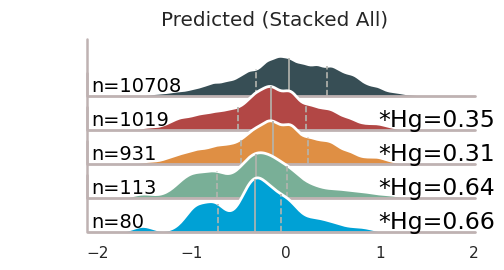

In [ ]:
# plot pred ridge ABCD
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Columns to test
test_columns = ['tvals_pred', 'cvals_pred', 'fvals_pred']
# Add dummy entries for empty rows
empty_rows = ['empty1', 'empty2']
empty_entries = pd.DataFrame({'Score': [np.nan] * 2, 'Type_Group': empty_rows})
pred_true_combined_with_empty = pd.concat([pred_pred_combined, empty_entries], ignore_index=True)

# color_list = ['#88bca0', '#ffb1c3', '#ec8597', '#bc5a6d', '#8e3047', '#fbfbfb', '#88bca0', '#ff9ddb', '#ffa27c', '#ff7070', '#c83e3a', '#fbfbfb', '#79af97', '#374e55', '#00a1d5', '#b24745', '#df8f44', '#fbfbfb']
color_list = ['#374e55', '#b24745', '#df8f44','#79af97' , '#00a1d5',  '#fbfbfb', '#374e55', '#b24745', '#df8f44','#79af97' , '#00a1d5','#fbfbfb', '#374e55', '#b24745', '#df8f44','#79af97' , '#00a1d5']

# Create a list of unique labels from Type_Group
unique_labels = ['tvals_pred_Non-ADHD', 'tvals_pred_ADHD-Tier 1',
       'tvals_pred_ADHD-Tier 2', 'tvals_pred_ADHD-Tier 3',
       'tvals_pred_ADHD-Tier 4', 'cvals_pred_Non-ADHD',
       'cvals_pred_ADHD-Tier 1', 'cvals_pred_ADHD-Tier 2',
       'cvals_pred_ADHD-Tier 3', 'cvals_pred_ADHD-Tier 4',
       'fvals_pred_Non-ADHD', 'fvals_pred_ADHD-Tier 1',
       'fvals_pred_ADHD-Tier 2', 'fvals_pred_ADHD-Tier 3',
       'fvals_pred_ADHD-Tier 4']
c_labels = ['', '',
       'Total', '',
       '', '',
       '', '',
       'Crystalised', '',
       '', '',
       '', '',
       'Fluid']
# Insert empty rows at specific positions
insert_positions = [5, 11]  # Insert after the 5th and 10th rows
for pos, empty_row in zip(insert_positions, empty_rows):
    unique_labels.insert(pos, empty_row)

# Reorder the DataFrame based on the new label order
pred_true_combined_with_empty['Type_Group'] = pd.Categorical(pred_true_combined_with_empty['Type_Group'], categories=unique_labels, ordered=True)
pred_true_combined_with_empty = pred_true_combined_with_empty.sort_values('Type_Group')
pred_true_combined_total = pred_true_combined_with_empty
pred_true_combined_total = pred_true_combined_with_empty[pred_true_combined_with_empty['Type_Group'].isin(unique_labels[0:5])]
pred_true_combined_total['Type_Group'] = pred_true_combined_total['Type_Group'].cat.remove_unused_categories()
# Plotting
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(5, start=2, rot=0, light=.7, dark=.3, reverse=False)
xlim = (pred_pred_combined['Score'].min(), pred_pred_combined['Score'].max() - 0.3 )
# xlim = (-4.5, 3.5 )

# Plot each score type using FacetGrid
g = sns.FacetGrid(pred_true_combined_total, row="Type_Group", aspect=10, height=.5, palette=pal, sharex=True, sharey=True)
g.map_dataframe(sns.kdeplot, "Score", bw_adjust=.5, clip_on=True, fill=True, alpha=1, linewidth=1.5, color= '#decbe4')
g.map_dataframe(sns.kdeplot, "Score", clip_on=True, color="w", lw=2, bw_adjust=.5)
# # g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


for i, ax in enumerate(g.axes.flat):
    if i < 25:
        # Check if the current axis has lines (KDE plots)
        if len(ax.collections) > 0:
            # Get the KDE collection (which contains the filled area)
            for collection in ax.collections:
                # Set the fill color from the color_list
                collection.set_facecolor(color_list[i ])#% len(color_list)
                collection.set_edgecolor('none')  # Optional: remove edge color if desired
            ax.relim()  # Recalculate limits
            ax.autoscale_view()  # Update view limits
# Add median lines and labels
for i, (ax, (label, group_data)) in enumerate(zip(g.axes.flat, pred_true_combined_total.groupby('Type_Group'))):
    # print(label)
    if i < 25:
        if label in empty_rows:
            ax.axis('off')  # Optionally turn off the axis
                    # Add white refline for empty rows
            ax.axhline(y=0, linewidth=2, linestyle="-", color='white', clip_on=False)
        else:
            # Calculate median
            median = group_data['Score'].mean()
            q1 = group_data['Score'].quantile(0.25)  
            q3 = group_data['Score'].quantile(0.75)
            kdeline = ax.lines[0]
            xs = kdeline.get_xdata()
            ys = kdeline.get_ydata()
            height = np.interp(median, xs, ys)
            height_q1 = np.interp(q1, xs, ys)
            height_q3 = np.interp(q3, xs, ys)
            ax.vlines(median, 0, height, color='#b4b5af', ls='-', linewidth=1.2)
            ax.vlines(q1, 0, height_q1, color='#b4b5af', ls='--', linewidth=1.2, )
            ax.vlines(q3, 0, height_q3, color='#b4b5af', ls='--', linewidth=1.2, )
            ss = f"n={len(group_data['Score'])}"

            ax.set_xlim(xlim)
            # Add row labels horizontally on the x-axis, right-aligned
            ax.text(-0.20, 0.1, '  ', ha='left', va='center', transform=ax.transAxes,
                    fontsize=12,  color='black')#fontweight='bold',
            ax.axhline(y=0, linewidth=2, linestyle="-", color='#bfb2b2', clip_on=False)
            # if i in [2,8,14]:
            #     ax.text(-0.05, 0.1, c_labels[i], ha='right', va='center', transform=ax.transAxes,
            #         fontsize=19, color='black', rotation='vertical')#fontweight='bold', 
            #     ax.text(1.25, 0.1, '          ', ha='right', va='center', transform=ax.transAxes,
            #         fontsize=12, fontweight='bold', color='black')
            ax.text(0.010, 0.17, ss , ha='left', va='center', transform=ax.transAxes,
                    fontsize=14,  color='black', )#fontweight='bold',fontname='DejaVu Sans'
            if 'Non' not in label[11:]:
                stat_res = abcd_calculate_stats([label[0:10]])
                stats_vals = f"{stat_res[label[0:10]][label[11:]]['boot_mean']}Hg={stat_res[label[0:10]][label[11:]]['hedges g']:.2f}"
                ax.text(0.75, 0.17, stats_vals , ha='left', va='center', transform=ax.transAxes,
                    fontsize=17,  color='black', )#fontweight='bold',fontname='DejaVu Sans'

            ax.set_xlim(xlim)
            ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
#         # print(xlim)
for ax in g.axes.flat:
    ax.axvline(x=xlim[0]-0.01, color='#bfb2b2', linewidth=1.8, linestyle='-', clip_on=False)
# Ensure no labels or ticks on y-axis
g.set(yticks=[], ylabel="")
g.set(xlabel="")
# Adjust spacing and remove the bottom and left spines
g.figure.subplots_adjust(hspace=-.40)
g.figure.suptitle("Predicted (Stacked All)", y = 1)
g.set_titles("")
g.despine(bottom=True, left=True)
# plt.savefig('/home/farzane/Desktop/Ridge - ABCD - ALLPredicted.svg', format='svg', dpi=300, bbox_inches='tight', pad_inches=0.2)


## Lytle

In [ ]:
# test statistical difference between observed and predicted (best stacked model)

def my_statistic(sample1, sample2):
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    return mean1 - mean2
def op_calculate_stats(test_columns):
    # t-test
    import pandas as pd
    from scipy.stats import ttest_ind

    # Assuming your dataframe is named df
    # Group names
    groups = ['ADHD', 'Non-ADHD']

    # Initialize a dictionary to collect t-test results
    ttest_results = {}

    # Perform t-test for each column between Non-ADHD and each ADHD tier group
    for column in test_columns:
        ttest_results[column] = {}
        for tier in groups[:-1]:  # Exclude Non-ADHD for inner loop
            # Filter data for Non-ADHD and current tier
            non_adhd_data = best_model_vals[best_model_vals['Group'] == 'Non-ADHD'][column].dropna()
            tier_data = best_model_vals[best_model_vals['Group'] == tier][column].dropna()
            n1 = len(non_adhd_data)
            n2 = len(tier_data)
            # Perform t-test
            mean1 = np.mean(non_adhd_data)
            mean2 = np.mean(tier_data)
            sd1 = np.std(non_adhd_data)
            sd2 = np.std(tier_data)
            t_stat, p_val = ttest_ind(non_adhd_data, tier_data, equal_var=False)  # Welch's t-test
            if p_val < 0.0001 :
                spval = '****'
            elif p_val < 0.001 :
                spval = '***'
            elif p_val < 0.01 :
                spval = '**'
            elif p_val < 0.05:
                spval = '*'
            elif p_val < 0.1:
                spval = '+'
            else:
                spval = ''

            # Calculate sample variances
            s1_squared = np.var(non_adhd_data, ddof=1)  # Variance with Bessel's correction
            s2_squared = np.var(tier_data, ddof=1)      # Variance with Bessel's correction

            # Calculate Welch-Satterthwaite degrees of freedom
            df = ((s1_squared / n1) + (s2_squared / n2))**2 / (((s1_squared / n1)**2 / (n1 - 1)) + ((s2_squared / n2)**2 / (n2 - 1)))

  
            # print(n1, n2 ,  tier , f"Degrees of freedom: {df:.2f}")

            glass_d = (mean2 - mean1) / sd1

            # Calculate standard deviations
            sd1c = np.std(non_adhd_data, ddof=1)
            sd2c = np.std(tier_data, ddof=1)

            # Calculate pooled standard deviation
            sd_pooled = np.sqrt(((n1 - 1) * sd1c**2 + (n2 - 1) * sd2c**2) / (n1 + n2 - 2))

            # Calculate Cohen's d
            cohen_d = (mean1 - mean2) / sd_pooled

            # Calculate correction factor for Hedges' g
            correction_factor = 1 - (3 / (4 * (n1 + n2 - 2) - 1))
            
            # Calculate Hedges' g
            hedges_g = cohen_d * correction_factor


            data = (non_adhd_data, tier_data)

            res = bootstrap(data, my_statistic, method='basic')
            # print('bootsrap mean' , tier, column)
            # print(my_statistic(non_adhd_data, tier_data))
            # print(res.confidence_interval)

            confidence_interval_mean = res.confidence_interval
            mean_comp = ('*' if confidence_interval_mean[0] > 0 and confidence_interval_mean[1] > 0 else
                        '*' if confidence_interval_mean[0] < 0 and confidence_interval_mean[1] < 0 else '')

            # Store the results
            ttest_results[column][tier] = {'t_stat': t_stat, 'p_val': spval, 'non_mean': mean1, 'adhd_mean': mean2, 'non_sd': sd1, 'adhd_sd': sd2, 'Glass Δ' : glass_d, 'cohen_d': cohen_d, 'hedges g': hedges_g , 'df': df, 'boot_mean' : mean_comp, 'boot_conf' : confidence_interval_mean}
            print(column, tier, p_val )


    return ttest_results

/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecate

tvals_true
tvals_true ADHD 0.00012806725197075485
cvals_true
cvals_true ADHD 0.001832504049787768
fvals_true
fvals_true ADHD 0.00019755011143624655


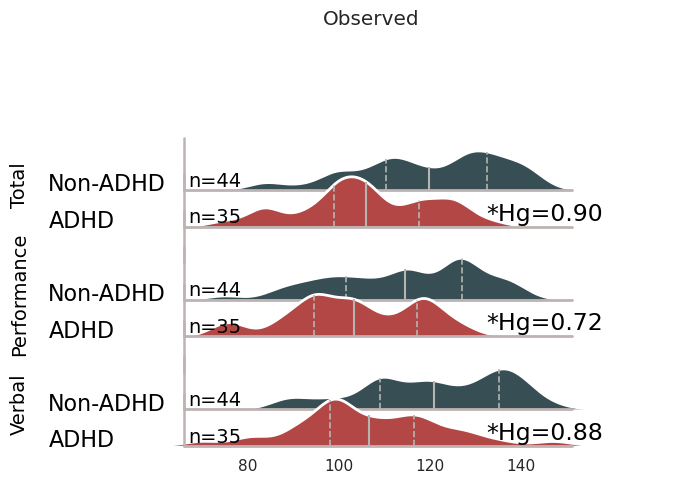

In [ ]:
# plot ridge op1 True values
# prepare data:
targ = 'FSIQ_'
model = 'rf2_output_fstd'
targ_list = ['VIQ_', 'PIQ_', 'FSIQ_']
test_set = '_op1' #'op2_'
model_list = ['rf2_output_fstd']# 'WmCntr2_s' : 'Spatial Nback contrasts',

tvals = joblib.load(plot_dir  + 'FSIQ_' + model + test_set +'_corr_res.joblib')
cvals = joblib.load(plot_dir  + 'VIQ_' + model + test_set +'_corr_res.joblib')
fvals = joblib.load(plot_dir  + 'PIQ_' + model + test_set +'_corr_res.joblib')
# best_model_tvals =  pd.concat([tvals['stacked']['WmCntr2_s']['All'][-2][1], tvals['stacked']['WmCntr2_s']['All'][-2][0]], axis=1)
best_model_tvals =  pd.concat([tvals['stacked']['WmCntr2_s']['All'][-2][1], all_cog1.iloc[:,2]], axis=1)

best_model_tvals.columns =  ['pred','true']
# best_model_cvals =  pd.concat([cvals['stacked']['WmCntr2_s']['All'][-2][1], cvals['stacked']['WmCntr2_s']['All'][-2][0]], axis=1)
best_model_cvals =  pd.concat([cvals['stacked']['Str2']['All'][-2][1],all_cog1.iloc[:,1]], axis=1)

best_model_cvals.columns =  ['pred','true']
# best_model_fvals = pd.concat([fvals['stacked']['WmCntr2_s']['All'][-2][1], fvals['stacked']['WmCntr2_s']['All'][-2][0]], axis=1)
best_model_fvals = pd.concat([fvals['stacked']['Str2']['All'][-2][1], all_cog1.iloc[:,0]], axis=1)

best_model_fvals.columns =  ['pred','true']
# Concatenate the DataFrames along the columns axis
best_model_vals = pd.concat([best_model_tvals, best_model_cvals, best_model_fvals], axis=1)
keys = ['{}_{}'.format(key, col) for key in ['tvals', 'cvals', 'fvals'] for col in ['pred', 'true']]

# Set new keys to the columns of the merged DataFrame
best_model_vals.columns = keys

# Columns to test
test_columns = ['tvals_true', 'cvals_true', 'fvals_true']

# best_model_vals = best_model_vals.loc[:, ~best_model_vals.columns.duplicated()]
group_indices = {
    'ADHD': list(adhd_cog1.index),
    'Non-ADHD': list(non_cog1.index)
}
best_model_vals['Group'] = ''
# Assign groups based on the indices
for group, indices in group_indices.items():
    f_ind = list(set(best_model_vals.index).intersection(set(indices)))
    best_model_vals.loc[f_ind, 'Group'] = group

best_model_vals = best_model_vals.reset_index()
# best_model_vals.columns =  ['pred','true','Group']
best_model_valst = best_model_vals.drop(columns=['tvals_pred', 'cvals_pred', 'fvals_pred'])
best_model_valsp = best_model_vals.drop(columns=['tvals_true', 'cvals_true','fvals_true'])


# Convert to long format
pred_true_long = best_model_valst.melt(id_vars=['participant_id', 'Group'], value_vars=['tvals_true', 'cvals_true', 'fvals_true'],
                                var_name='Type', value_name='Score')

# Convert to long format
pred_pred_long = best_model_valsp.melt(id_vars=['participant_id', 'Group'], value_vars=['tvals_pred', 'cvals_pred', 'fvals_pred'],
                                var_name='Type', value_name='Score')

pred_true_long.rename(columns={'participant_id': 'Original_Index'}, inplace=True)
pred_pred_long.rename(columns={'participant_id': 'Original_Index'}, inplace=True)

pred_true_long.index = pred_true_long['Original_Index']
pred_true_long = pred_true_long.drop(columns=['Original_Index'])

# Create a new DataFrame with combined 'Type' and 'Group'
pred_true_combined = pred_true_long.copy()
pred_true_combined['Type_Group'] = pred_true_combined['Type'] + '_' + pred_true_combined['Group'].astype(str)

# drop the original 'Type' and 'Group' columns 
pred_true_combined = pred_true_combined.drop(columns=['Type', 'Group'])

pred_pred_long.index = pred_pred_long['Original_Index']
pred_pred_long = pred_pred_long.drop(columns=['Original_Index'])

# Create a new DataFrame with combined 'Type' and 'Group'
pred_pred_combined = pred_pred_long.copy()
pred_pred_combined['Type_Group'] = pred_pred_combined['Type'] + '_' + pred_pred_combined['Group'].astype(str)

# drop the original 'Type' and 'Group' columns 
pred_pred_combined = pred_pred_combined.drop(columns=['Type', 'Group'])

# color_list = ['#f59090', '#669695', '#fbfbfb','#f59090', '#669695', '#fbfbfb', '#f59090', '#669695']

color_list = ['#374e55', '#b24745', '#fbfbfb', '#374e55', '#b24745', '#fbfbfb', '#374e55', '#b24745']

# Add dummy entries for empty rows
empty_rows = ['empty1', 'empty2']
empty_entries = pd.DataFrame({'Score': [np.nan] * 2, 'Type_Group': empty_rows})
pred_true_combined_with_empty = pd.concat([pred_true_combined, empty_entries], ignore_index=True)



# Create a list of unique labels from Type_Group
unique_labels = ['tvals_true_Non-ADHD', 'tvals_true_ADHD', 'cvals_true_Non-ADHD', 'cvals_true_ADHD', 'fvals_true_Non-ADHD', 'fvals_true_ADHD']
c_labels = ['Total', '', '', 'Performance', '', '', 'Verbal']

# Insert empty rows at specific positions
insert_positions = [2, 5]  # Insert after the 5th and 10th rows
for pos, empty_row in zip(insert_positions, empty_rows):
    unique_labels.insert(pos, empty_row)

# Reorder the DataFrame based on the new label order
pred_true_combined_with_empty['Type_Group'] = pd.Categorical(pred_true_combined_with_empty['Type_Group'], categories=unique_labels, ordered=True)
pred_true_combined_with_empty = pred_true_combined_with_empty.sort_values('Type_Group')
pred_true_combined_total = pred_true_combined_with_empty
# pred_true_combined_total = pred_true_combined_with_empty[pred_true_combined_with_empty['Type_Group'].isin(unique_labels[0:2])]
# pred_true_combined_total['Type_Group'] = pred_true_combined_total['Type_Group'].cat.remove_unused_categories()
# Plotting
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(5, start=2, rot=0, light=.7, dark=.3, reverse=False)
xlim = (pred_true_combined['Score'].min() - 4 , pred_true_combined['Score'].max() + 4)

# Plot each score type using FacetGrid
g = sns.FacetGrid(pred_true_combined_total, row="Type_Group", aspect=10, height=.5, palette=pal, sharex=True, sharey=True)
g.map_dataframe(sns.kdeplot, "Score", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5, color= 'darkgray')
g.map_dataframe(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    # Check if the current axis has lines (KDE plots)
    if len(ax.collections) > 0:
        # Get the KDE collection (which contains the filled area)
        for collection in ax.collections:
            # Set the fill color from the color_list
            collection.set_facecolor(color_list[i % len(color_list)])
            collection.set_edgecolor('none')  # Optional: remove edge color if desired
        ax.relim()  # Recalculate limits
        ax.autoscale_view()  # Update view limits

# Add median lines and labels
for i, (ax, (label, group_data)) in enumerate(zip(g.axes.flat, pred_true_combined_total.groupby('Type_Group'))):
    # print(label)

    if label in empty_rows:
        ax.axis('off')  # Optionally turn off the axis
                # Add white refline for empty rows
        ax.axhline(y=0, linewidth=2, linestyle="-", color='white', clip_on=False)
    else:
        # Calculate median
        median = group_data['Score'].mean()
        q1 = group_data['Score'].quantile(0.25)  
        q3 = group_data['Score'].quantile(0.75)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        height = np.interp(median, xs, ys)
        height_q1 = np.interp(q1, xs, ys)
        height_q3 = np.interp(q3, xs, ys)
        ax.vlines(median, 0, height, color='#b4b5af', ls='-')
        ax.vlines(q1, 0, height_q1, color='#b4b5af', ls='--', linewidth=1.2, )
        ax.vlines(q3, 0, height_q3, color='#b4b5af', ls='--', linewidth=1.2, )
        ax.set_xlim(xlim)
        ss = f"n={len(group_data['Score'])}"
        # Add row labels horizontally on the x-axis, right-aligned
        ax.text(-0.35, 0.1, label[11:], ha='left', va='center', transform=ax.transAxes,
                fontsize=16,  color='black')#fontweight='bold',
        ax.axhline(y=0, linewidth=2, linestyle="-", color='#bfb2b2', clip_on=False)
        if i in [0,3,6]:
            ax.text(-0.4, 0.1, c_labels[i], ha='right', va='center', transform=ax.transAxes,
                fontsize=14, color='black', rotation='vertical')#fontweight='bold', 
            ax.text(1.25, 0.1, '          ', ha='right', va='center', transform=ax.transAxes,
                fontsize=12, fontweight='bold', color='black')
        ax.text(0.010, 0.17, ss , ha='left', va='center', transform=ax.transAxes,
                fontsize=14,  color='black', )#fontweight='bold',fontname='DejaVu Sans'
        if 'Non' not in label[11:]:
            print(label[0:10])
            stat_res = op_calculate_stats([label[0:10]])
            stats_vals = f"{stat_res[label[0:10]][label[11:]]['boot_mean']}Hg={stat_res[label[0:10]][label[11:]]['hedges g']:.2f}" #  t({stat_res[label[0:10]][label[11:]]['df']:.2f}) = {stat_res[label[0:10]][label[11:]]['t_stat']:.2f}, 

            ax.text(0.78, 0.24, stats_vals , ha='left', va='center', transform=ax.transAxes,
                fontsize=17,  color='black')#fontweight='bold',

for ax in g.axes.flat:
    ax.axvline(x=xlim[0]-0.01, color='#bfb2b2', linewidth=1.8, linestyle='-', clip_on=False)




# Ensure no labels or ticks on y-axis
g.set(yticks=[], ylabel="")
g.set(xlabel="")
# Adjust spacing and remove the bottom and left spines
g.figure.subplots_adjust(hspace=-.30)
g.figure.suptitle("Observed", y=1.2)
g.set_titles("")
g.despine(bottom=True, left=True)
plt.savefig('/home/farzane/Desktop/Ridge - OP1 - ALLObserved.svg', format='svg', dpi=300, bbox_inches='tight', pad_inches=0.1)


/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecate

tvals_pred
tvals_pred ADHD 0.051312971006857076
cvals_pred
cvals_pred ADHD 0.24700316550483245
fvals_pred
fvals_pred ADHD 0.23528162844190958


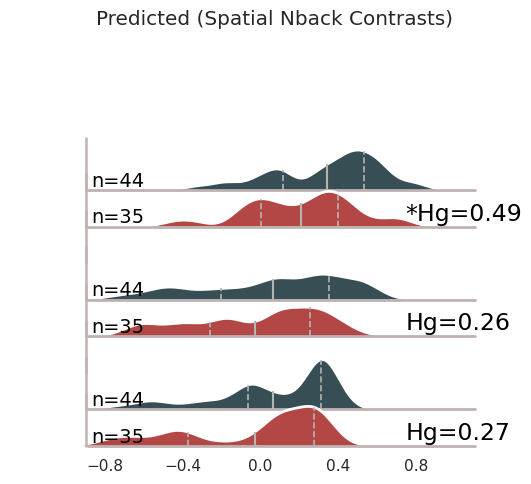

In [ ]:
#ridge  OP1 pred
test_columns  = ['tvals_pred', 'cvals_pred', 'fvals_pred']
# Add dummy entries for empty rows
empty_rows = ['empty1', 'empty2']
empty_entries = pd.DataFrame({'Score': [np.nan] * 2, 'Type_Group': empty_rows})
pred_true_combined_with_empty = pd.concat([pred_pred_combined, empty_entries], ignore_index=True)

# Create a list of unique labels from Type_Group
unique_labels = ['tvals_pred_Non-ADHD', 'tvals_pred_ADHD', 'cvals_pred_Non-ADHD', 'cvals_pred_ADHD', 'fvals_pred_Non-ADHD', 'fvals_pred_ADHD']
c_labels = ['Total', '', '', 'Performance', '', '', 'Verbal']

# Insert empty rows at specific positions
insert_positions = [2, 5]  # Insert after the 5th and 10th rows
for pos, empty_row in zip(insert_positions, empty_rows):
    unique_labels.insert(pos, empty_row)

# Reorder the DataFrame based on the new label order
pred_true_combined_with_empty['Type_Group'] = pd.Categorical(pred_true_combined_with_empty['Type_Group'], categories=unique_labels, ordered=True)
pred_true_combined_with_empty = pred_true_combined_with_empty.sort_values('Type_Group')
pred_true_combined_total = pred_true_combined_with_empty
# pred_true_combined_total = pred_true_combined_with_empty[pred_true_combined_with_empty['Type_Group'].isin(unique_labels[0:2])]
# pred_true_combined_total['Type_Group'] = pred_true_combined_total['Type_Group'].cat.remove_unused_categories()
# color_list = ['#f59090', '#669695', '#fbfbfb','#f59090', '#669695', '#fbfbfb', '#f59090', '#669695']
color_list = ['#374e55', '#b24745', '#fbfbfb', '#374e55', '#b24745', '#fbfbfb', '#374e55', '#b24745']


# Plotting
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(5, start=2, rot=0, light=.7, dark=.3, reverse=False)
xlim = (pred_pred_combined['Score'].min() - 0.12  , pred_pred_combined['Score'].max() + 0.3 )

# Plot each score type using FacetGrid
g = sns.FacetGrid(pred_true_combined_total, row="Type_Group", aspect=10, height=.5, palette=pal, sharex=True, sharey=True)
g.map_dataframe(sns.kdeplot, "Score", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5, color= 'darkgray')
g.map_dataframe(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    # Check if the current axis has lines (KDE plots)
    if len(ax.collections) > 0:
        # Get the KDE collection (which contains the filled area)
        for collection in ax.collections:
            # Set the fill color from the color_list
            collection.set_facecolor(color_list[i % len(color_list)])
            collection.set_edgecolor('none')  # Optional: remove edge color if desired
        ax.relim()  # Recalculate limits
        ax.autoscale_view()  # Update view limits

# Add median lines and labels
for i, (ax, (label, group_data)) in enumerate(zip(g.axes.flat, pred_true_combined_total.groupby('Type_Group'))):
    # print(label)

    if label in empty_rows:
        ax.axis('off')  #  turn off the axis
                # Add white refline for empty rows
        ax.axhline(y=0, linewidth=2, linestyle="-", color='white', clip_on=False)
    else:
        # Calculate mediantrue
        median = group_data['Score'].mean()
        q1 = group_data['Score'].quantile(0.25)  
        q3 = group_data['Score'].quantile(0.75)
        kdeline = ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        height = np.interp(median, xs, ys)
        height_q1 = np.interp(q1, xs, ys)
        height_q3 = np.interp(q3, xs, ys)
        ax.vlines(median, 0, height, color='#b4b5af', ls='-')
        ax.vlines(q1, 0, height_q1, color='#b4b5af', ls='--', linewidth=1.2, )
        ax.vlines(q3, 0, height_q3, color='#b4b5af', ls='--', linewidth=1.2, )
        ax.set_xlim(xlim)
        ss = f"n={len(group_data['Score'])}"
        # Add row labels horizontally on the x-axis, right-aligned
        ax.text(-0.20, 0.1, '  ', ha='left', va='center', transform=ax.transAxes,
                fontsize=17,  color='black')#fontweight='bold',
        ax.axhline(y=0, linewidth=2, linestyle="-", color='#bfb2b2', clip_on=False)
        # if i in [2,8,14]:
        #     ax.text(-0.05, 0.1, c_labels[i], ha='right', va='center', transform=ax.transAxes,
        #         fontsize=19, color='black', rotation='vertical')#fontweight='bold', 
        #     ax.text(1.25, 0.1, '          ', ha='right', va='center', transform=ax.transAxes,
        #         fontsize=12, fontweight='bold', color='black')
        ax.text(0.010, 0.17, ss , ha='left', va='center', transform=ax.transAxes,
                fontsize=14,  color='black', )#fontweight='bold',fontname='DejaVu Sans'
        if 'Non' not in label[11:]:
            print(label[0:10])
            stat_res = op_calculate_stats([label[0:10]])
            stats_vals = f"{stat_res[label[0:10]][label[11:]]['boot_mean']}Hg={stat_res[label[0:10]][label[11:]]['hedges g']:.2f}" #  t({stat_res[label[0:10]][label[11:]]['df']:.2f}) = {stat_res[label[0:10]][label[11:]]['t_stat']:.2f}, 

            ax.text(0.82, 0.24, stats_vals , ha='left', va='center', transform=ax.transAxes,
                fontsize=17,  color='black')#fontweight='bold',

for ax in g.axes.flat:
    ax.axvline(x=xlim[0]-0.01, color='#bfb2b2', linewidth=1.8, linestyle='-', clip_on=False)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))

# Ensure no labels or ticks on y-axis
g.set(yticks=[], ylabel="")
g.set(xlabel="")

# Adjust spacing and remove the bottom and left spines
g.figure.subplots_adjust(hspace=-.30)
g.figure.suptitle("Predicted (Spatial Nback Contrasts)", y=1.2)
g.set_titles("")
g.despine(bottom=True, left=True)
plt.savefig('/home/farzane/Desktop/Ridge - OP1 - AllPredicted.svg', format='svg', dpi=300, bbox_inches='tight', pad_inches=0.1)


## 4. Scatter plot 
### for top stacked and single models (among each modality)

## ABCD

/tmp/ipykernel_249492/497049891.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


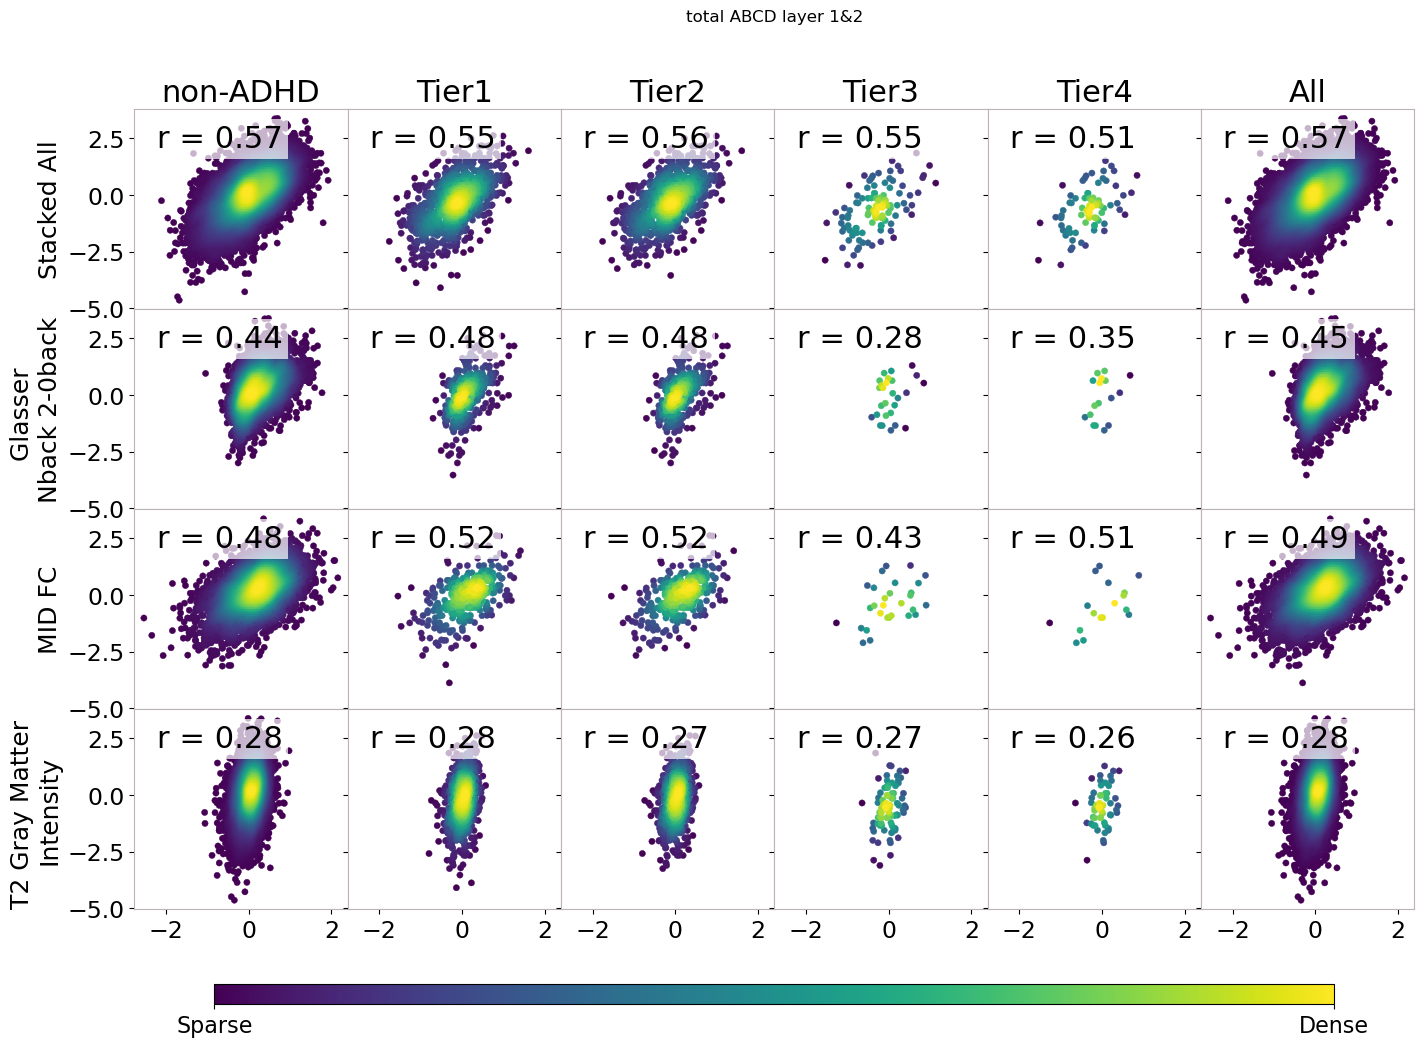

In [ ]:
## abcd l1 and l2 scatter plot
import matplotlib.colors as mcolors
# Layer 1-2  scatter plot
targ_list = ['total_']#, 'cryst_', 'fluid_'
targ_names = ['Total', 'Crystalised', 'Fluid']
model_list = ['eN1']
color_list = ['#b24745', '#df8f44','#2eb97b' , '#00a1d5',  '#374e55', '#826b88']

model1 = 'mnct_enet1'
model3 = 'eN1'
model2 = 'ntrf2'
groups = ['non-ADHD', 'Tier1', 'Tier2', 'Tier3', 'Tier4', 'All']
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 10), sharey=True, sharex=True)

for t, targ in enumerate([targ_list[0]]):
    corr_results1 = joblib.load(plot_dir + targ + model3 + '_corr_res.joblib')
    corr_results2 = joblib.load(plot_dir + targ + model3 + '_abcd_corr_res.joblib')
    corr_results3 = joblib.load(plot_dir + targ + model2 + '_corr_res.joblib')
    corr_results4 = joblib.load(plot_dir + targ + model1 + '_corr_res.joblib')
    mnct_dict = {'cntr' : corr_results4.pop('cntr')}
    corr_results = {**corr_results1, **corr_results2, **corr_results3, **mnct_dict}
    # Update corr_results dictionary with meaningful names
    updated_corr_results = {}
    for set_name, features in corr_results.items():
        updated_corr_results[set_name] = {}
        for f_name, data in features.items():
            if f_name in l12_labels:
                new_name = l12_labels[f_name]
                updated_corr_results[set_name][new_name] = data

    # all_corr_res = {**updated_corr_results, **updated_corr_results}
    modal_list = [('stacked','Stacked All'), ('cntr','Glasser \nNback 2-0back'), ('conn','MID FC'), ('smri','T2 Gray Matter \nIntensity')]
    for m , modal in enumerate(modal_list):
        for c,g in enumerate(groups):    
            plot_obj = updated_corr_results[modal[0]][modal[1]][g]
            x = plot_obj[0][1]
            y = plot_obj[0][0]

            # Calculate the point density
            xy = np.vstack([x,y])
            z = gaussian_kde(xy)(xy)
            # Sort the points by density, so that the densest points are plotted last
            idx = z.argsort()
            x1, y1, z = x[idx], y[idx], z[idx]
            # Normalize the density values to [0, 1]
            z_normalized = (z - np.min(z)) / (np.max(z) - np.min(z))
            scatter_color = color_list[c]
            rgba_color = mcolors.to_rgba_array(scatter_color)  # Convert base color to RGBA format
            # Create an array of RGBA colors, one for each point
            rgba_colors = np.tile(rgba_color, (len(z_normalized), 1))  # Create (n_points, 4) array
            rgba_colors[:, -1] = z_normalized 
            if plot_obj[1] < 0:
                axes[m,c].scatter(x1 , y1,   cmap = 'viridis', c=z_normalized, s=20,   linewidths=0.3) #color='blue',edgecolors='r'facecolors='r',facecolors='none'c=z_normalized, edgecolor=scatter_color,
            else:
                axes[m,c].scatter(x1 , y1,  cmap = 'viridis', c=z_normalized, s=20,  linewidths=0.3) #color='blue',edgecolors='g',facecolors='g', c=z_normalized,, edgecolor=scatter_color,
                        # Add text with the correlation value

            # axes[m,c].text(0.695, 0.85, f'r = {plot_obj[2]:.2f}', 
            #         transform=axes[m,c].transAxes,fontsize=20, ha='right', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7), fontfamily='sans-serif')# \n n = {int(plot_obj[3])}
                
            p_corr, _ = pearsonr(x, y)
            axes[m,c].text(0.695, 0.85, f'r = {p_corr:.2f}', 
                    transform=axes[m,c].transAxes,fontsize=22, ha='right', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7), fontfamily='sans-serif')# \n n = {int(plot_obj[3])}
            axes[m, c].tick_params(axis='both', which='major', labelsize=17)
            if t + m == 0:
                axes[m,c].set_title(f'{g}', fontsize=22)#Modality: {modality}, 
            # Set a common title for the row
            # axes[m,0].set_ylabel(f'{targ_names[t]}', fontsize=15)
            axes[m,0].set_ylabel(f'{modal_list[m][1]}', fontsize=18)#fontweight='bold'
        #, fontweight='bold'
            # Format y-axis ticks as float with 2 decimals
            # for ax in axes.flat:
            #     ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
# fig.text(0.03, 0.78, modal_list[0][1], va='center', rotation='vertical', fontsize=12)
# fig.text(0.03, 0.50, modal_list[1][1], va='center', rotation='vertical', fontsize=12)
# fig.text(0.03, 0.23, modal_list[2][1], va='center', rotation='vertical', fontsize=12)
# Set light grey borders for each subplot
for ax in axes.flat:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    for spine in ax.spines.values():
        spine.set_edgecolor('#bfb2b2')  # Light grey color for the borders
# Create a colormap for the density bar
cmap = plt.cm.viridis  # Using the same colormap as the scatter plot
norm = mcolors.Normalize(vmin=0, vmax=1)

# Add a colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.005, 0.7, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')

# Set ticks and labels for the colorbar
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Sparse', 'Dense'])
cbar.ax.tick_params(labelsize=16)  # Customize tick size

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.00, hspace=0.0)  
# # Add general x-axis label at the center bottom of the plot
# fig.text(0.5, -0.001, 'Observed', ha='center', va='center', fontsize=20, fontfamily='sans-serif')

# # Add general y-axis label on the right side, centered and rotated
# fig.text(0.999, 0.5, 'Predicted', ha='center', va='center', rotation=270, fontsize=20, fontfamily='sans-serif')

fig.figure.suptitle("total ABCD layer 1&2", y=1, fontfamily='sans-serif')
plt.savefig('/home/farzane/Desktop/total ABCD layer 1&2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

## Lytle

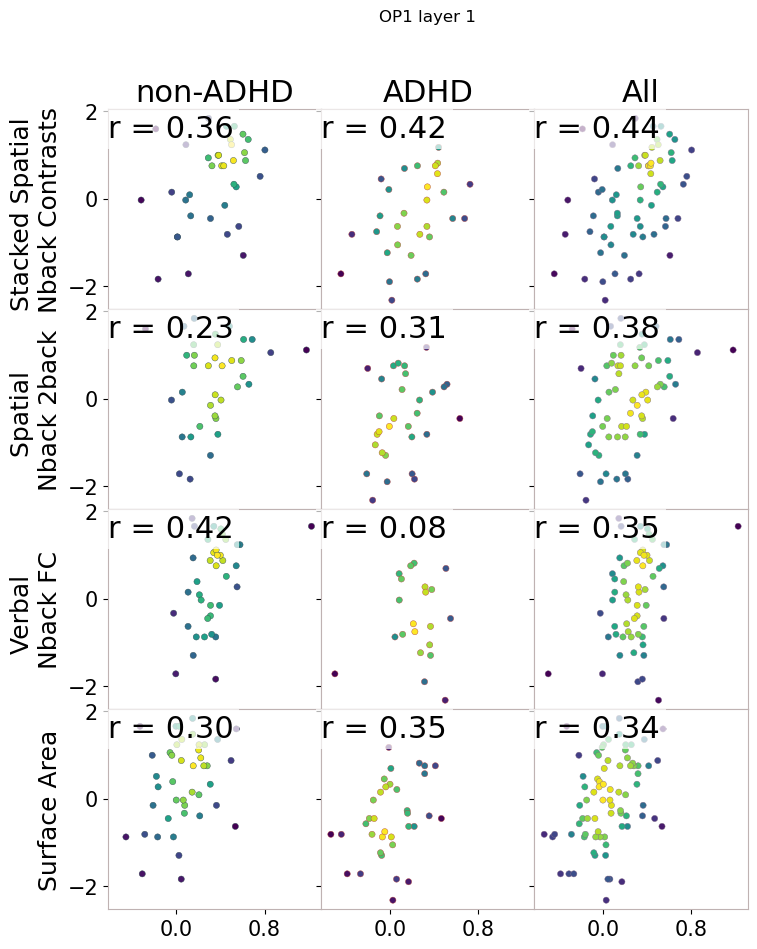

In [ ]:
#op1 scatter plot
# targ = 'FSIQ_'
model = 'enet1_output_fstd'
model2 = 'rf2_output_fstd'
targ_list = ['FSIQ_']#, 'PIQ_', 'VIQ_'
test_set = '_op1' #'op2_'
color_list = ['#374e55', '#b24745', '#826b88']  # Added one more color for the 6th group
op1l12_labels =  {
'cort': 'Cortical thickness',
'surf': 'Surface Area',
'subc': 'Subcortical volume',
'VolBrain': 'Total brain volume',
'verbal': 'Verbal \nNback FC',
'spatial' : 'Spatial \nNback FC',
'tfc': 'Task FC',
'gtfc': 'Task FC using General FC model',
'cntr_twoback_task-verbal': 'Verbal \nNback 2back ',
'cntr_oneback_task-verbal' : 'Verbal Nback 1back',
'cntr_twoback-oneback_task-verbal' : 'Verbal Nback 2-1back',
'cntr_twoback_task-spatial': 'Spatial \nNback 2back',
'cntr_oneback_task-spatial' : 'spatial Nback 1back',
'cntr_twoback-oneback_task-spatial': 'Spatial Nback 2-1back',
# 'All8_v' : 'sMRI + tFC + nback 2-0 contrasts',
'All9_v' : 'sMRI + General FC + Verbal Nback contrasts',
'All10_v' : 'sMRI + nback FC + Verbal Nback contrasts',
'All9_s' : 'sMRI + General FC + \nSpatial Nback contrasts',
'All10_s' : 'sMRI + nback FC + Spatial Nback contrasts',
# 'StrtFC' : 'sMRI + tFC',
'StrgFC' : 'sMRI + General FC',
'Str2' : 'sMRI',
'WmCntr2_v' : 'Verbal Nback Contrasts',
'WmCntr2_s' : 'Stacked Spatial \nNback Contrasts',
}


groups = ['non-ADHD', 'ADHD', 'All']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 10), sharey=True, sharex=True)

for t, targ in enumerate(targ_list):
    corr_results1 = joblib.load(plot_dir + targ + model + test_set + '_corr_res.joblib')
    corr_results2 = joblib.load(plot_dir + targ + model2 + test_set+ '_corr_res.joblib')
    corr_results = {**corr_results1, **corr_results2}
    # Update corr_results dictionary with meaningful names
    updated_corr_results = {}
    for set_name, features in corr_results.items():
        updated_corr_results[set_name] = {}
        for f_name, data in features.items():
            if f_name in op1l12_labels:
                new_name = op1l12_labels[f_name]
                updated_corr_results[set_name][new_name] = data
    modal_list = [('stacked','Stacked Spatial \nNback Contrasts'),('cntr','Spatial \nNback 2back'), ('conn','Verbal \nNback FC'), ('smri','Surface Area')] #('conn','Inhibition FC in Nback FC model'), 
    for m , modal in enumerate(modal_list):
        for c,g in enumerate(groups):    
            plot_obj = updated_corr_results[modal[0]][modal[1]][g]                
      
            x = plot_obj[0][1]
            y = plot_obj[0][0]

            # Calculate the point density
            xy = np.vstack([x,y])
            z = gaussian_kde(xy)(xy)
            # Sort the points by density, so that the densest points are plotted last
            idx = z.argsort()
            x1, y1, z = x[idx], y[idx], z[idx]
            # Normalize the density values to [0, 1]
            z_normalized = (z - np.min(z)) / (np.max(z) - np.min(z))
            scatter_color = color_list[c]
            rgba_color = mcolors.to_rgba_array(scatter_color)  # Convert base color to RGBA format
            # Create an array of RGBA colors, one for each point
            rgba_colors = np.tile(rgba_color, (len(z_normalized), 1))  # Create (n_points, 4) array
            rgba_colors[:, -1] = z_normalized 
            if plot_obj[1] < 0:
                axes[m,c].scatter(x1 , y1,  cmap = 'viridis', c=z_normalized, s=20,  edgecolor=scatter_color, linewidths=0.3) #color='blue',edgecolors='r'facecolors='r',facecolors='none'c=z_normalized, 
            else:
                axes[m,c].scatter(x1 , y1,  cmap = 'viridis', c=z_normalized, s=20, edgecolor=scatter_color, linewidths=0.3) #color='blue',edgecolors='g',facecolors='g', c=z_normalized,, 
                        # Add text with the correlation value
            p_corr, _ = pearsonr(x, y)
            axes[m,c].text(0.0, 0.9, f'r = {p_corr:.2f}', 
                    transform=axes[m,c].transAxes,fontsize=22, ha='left', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))# \n n: {int(plot_obj[3])}
            axes[m, c].tick_params(axis='both', which='major', labelsize=15)
            if t == 0:
                axes[t,c].set_title(f'{g}', fontsize=22)#Modality: {modality}, 
            # Set a common title for the row
            axes[m,0].set_ylabel(f'{modal[1]}', fontsize=18)
            # Format y-axis ticks as float with 2 decimals
            # for ax in axes.flat:
            #     ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
# Add vertical label on the left side of the plot
# fig.text(-0.05, 0.5, 'Surface area', va='center', rotation='vertical', fontsize=15)#, fontweight='bold'
# Set light grey borders for each subplot
for ax in axes.flat:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    
    for spine in ax.spines.values():
        spine.set_edgecolor('#bfb2b2')  # Light grey color for the borders
fig.figure.suptitle("OP1 layer 1", y=1)
# Adjust the layout
plt.tight_layout()
# Show the plot
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.00, hspace=0.0)  
plt.savefig('/home/farzane/Desktop/total op1 layer 1&2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

## 5. Feature Importance

## ABCD Stacked
### SHAP values - bar plot

In [ ]:
# Layer 2 - ABCD - shaps
root_dir = '/media/hcs-sci-psy-narun/ABCC/fmriresults01/derivatives/ML_Tables/nesi_outputs/std_applicability/'

targ_list = ['total_'] #'total_', 'cryst_','fluid_'

model_list = ['ntrf2']#,'pls','eN1''rf2''eN2',
for model in model_list:
      for targ in targ_list:
            model_outs = joblib.load(root_dir + targ + model + '.joblib')


In [ ]:
all1_shaps = []
all2_shaps = []
for i in range(0,21):
    f_shaps = model_outs[f"Fold_{i}"]['stacked']['nAll1_abcd']['model']['shap']
    # print(int(f_shaps.shape[1]/2))
    n_f = int(f_shaps.shape[1]/2)
    mean_subj1 = np.mean(np.abs(f_shaps[:, :n_f]), axis=0)
    mean_subj2 = np.mean(np.abs(f_shaps[:, n_f:]), axis=0)
    mean_subj1 = mean_subj1.reshape(1, n_f)
    mean_subj2 = mean_subj2.reshape(1, n_f)
    cols = model_outs[f"Fold_{i}"]['stacked']['nAll1_abcd']['data']['xtrain'].columns
    column_sum = mean_subj1 + mean_subj2
    cleaned_cols = [col.replace('_l', '') for col in cols]
    f1_shaps = pd.DataFrame(column_sum, columns = cleaned_cols[:n_f])

    all1_shaps.append(f1_shaps)
# Concatenate the DataFrames, aligning on columns and ignoring missing ones
combined_df1 = pd.DataFrame(pd.concat(all1_shaps, axis=0, sort=False))

# Calculate the mean across the rows for each column, skipping NaNs
average_df1 = combined_df1.mean(axis=0)
std_df1 = combined_df1.std(axis=0)
# ave_shaps1 = average_df1.transpose()
# std_shaps1 = std_df1.transpose()
sorted_shaps1 = average_df1.sort_values(ascending=False)
sorted_std1 = std_df1.sort_values(ascending=False)

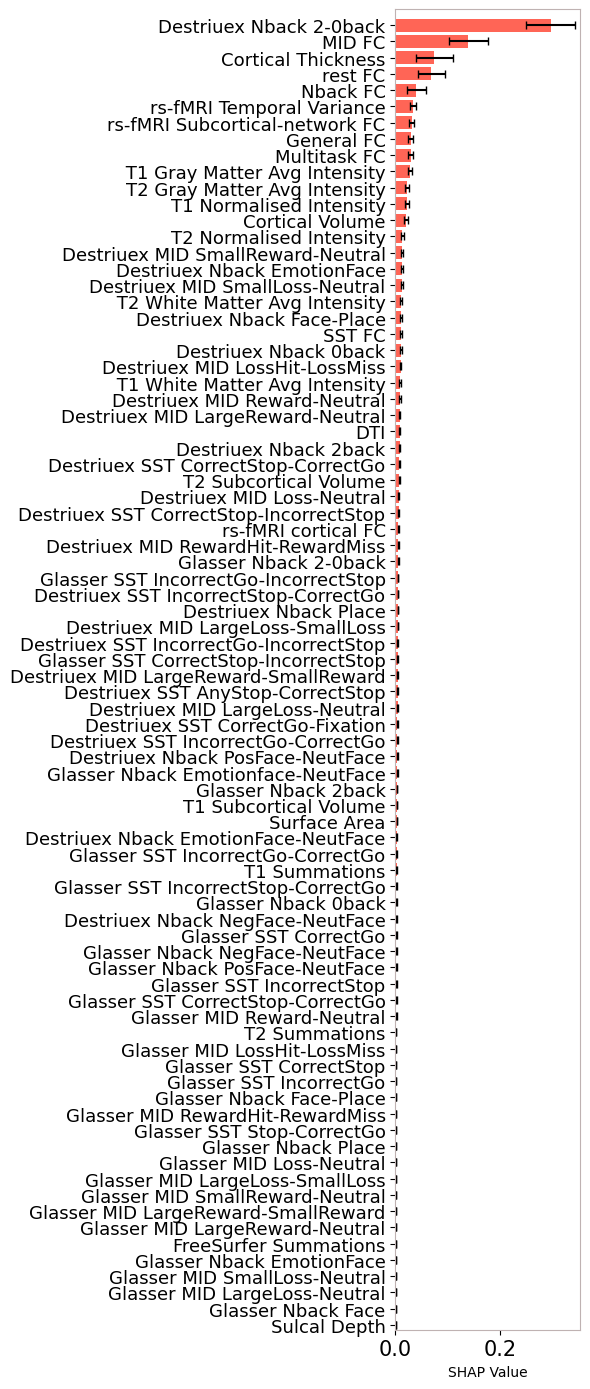

In [ ]:
# Filter to keep only the indices that exist in l1_labels
filtered_shaps1 = sorted_shaps1[sorted_shaps1.index.isin(l1_labels.keys())]
filtered_std1 = sorted_std1[sorted_std1.index.isin(l1_labels.keys())]

# Convert the indices to readable names using l1_labels
readable_names = [l1_labels.get(name, name) for name in filtered_shaps1.index]
filtered_shaps1.index = readable_names

# Plot the filtered SHAP values
plt.figure(figsize=(6, 14))
plt.barh(filtered_shaps1.index, filtered_shaps1.values, xerr=filtered_std1.values, color='#ff6556', capsize=3)

# Add labels and title
plt.xlabel('SHAP Value')
# plt.ylabel('Features')
# plt.title('Average SHAP Values with Error Bars (Standard Deviation)')
plt.ylim(bottom=-1, top=len(filtered_shaps1.index) - 0.7)
plt.xlim(0, filtered_shaps1.values.max() + filtered_std1.values.max() + 0.01)
# Invert y-axis to have the largest values at the top
plt.gca().invert_yaxis()
plt.yticks(fontsize=13)  # Adjust the font size as needed

# Customize ticks and borders
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=15)
for spine in ax.spines.values():
    spine.set_edgecolor('#bfb2b2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## ABCD Single

### Best connectivity-based model

In [ ]:
# Layer 1 - ABCD -  betas
root_dir = '/media/hcs-sci-psy-narun/ABCC/fmriresults01/derivatives/ML_Tables/nesi_outputs/std_applicability/'
targ_list = ['total_'] #'total_','fluid_'','fluid_', 'cryst_''total_', 'cryst_','fluid_'
model_list = ['enet1']#,'pls','eN1''rf2''eN2',
for model in model_list:
      for targ in targ_list:
            pls_outs = joblib.load(root_dir + targ + 'conn_pls' + '_output_fstd.joblib')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
original_feature_names = joblib.load(root_dir + 'connmat_headers')
def pls_explained_variance(pls, Y_true, do_plot=True):
    r2 = np.zeros(pls.n_components)
    for i in range(0, pls.n_components):
        Y_pred = (np.dot(pls.x_scores_[:, i][:, np.newaxis],
                         pls.y_loadings_[:, i][:, np.newaxis].T) * pls._y_std   
                  + pls._y_mean)
        r2[i] = r2_score(Y_true, Y_pred)

    if do_plot:
        component = np.arange(pls.n_components) + 1
        plt.plot(component, r2, '.-')
        plt.xticks(component)
        plt.xlabel('PLS Component #'), plt.ylabel('r2')
        plt.title(f'Summed individual r2: {np.sum(r2):.3f}')#, 'f'Overall r2: {overall_r2:.3f}
        plt.show()

    return r2 #, overall_r2
Y = pls_outs['conn_mid']['data']['yttrain'].values
best_pls = pls_outs['conn_mid']['model']['best_model']

var_weights = pls_explained_variance(best_pls, Y)

# Step 1: Get PLS component weights
pls_weights = best_pls.x_weights_  # Shape (n_features, n_components)
pls_var_weights = np.dot(pls_weights, var_weights)

coef_df = pd.DataFrame({
    'Feature': original_feature_names[1:],
    'Coefficient': pls_var_weights
})


In [ ]:
# Split 'Feature' into two separate columns for ROI1 and ROI2
coef_df[['ROI1', 'ROI2']] = coef_df['Feature'].str.split('_&_', expand=True)
# Create a list of unique ROIs
unique_rois = np.unique(np.concatenate([coef_df['ROI1'], coef_df['ROI2']]))

In [ ]:
coef_df

,Feature,Coefficient,ROI1,ROI2
0,L_V1_&_L_MST,0.000513,L_V1,L_MST
1,L_V1_&_L_V6,0.000153,L_V1,L_V6
2,L_V1_&_L_V2,0.001430,L_V1,L_V2
3,L_V1_&_L_V3,0.001063,L_V1,L_V3
4,L_V1_&_L_V4,0.001351,L_V1,L_V4
...,...,...,...,...
71626,putamen_right_&_thalamus_right,-0.000025,putamen_right,thalamus_right
71627,putamen_right_&_brainStem,0.000803,putamen_right,brainStem
71628,thalamus_left_&_thalamus_right,0.000229,thalamus_left,thalamus_right
71629,thalamus_left_&_brainStem,0.001342,thalamus_left,brainStem


In [ ]:
roi_network_df =  pd.read_csv('/home/farzane/Desktop/Random files/groi_colenetwork_mapping.csv', index_col=0)
ids = hcp.mmp.map_all
unique_networks = roi_network_df['Cole_net_name'].dropna().unique()

In [ ]:
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mne_connectivity.viz import plot_connectivity_circle
import matplotlib.cm as cm

# Sample adjacency matrix and list of unique ROIs
# Define your colormap (you can use 'coolwarm', 'RdBu', 'viridis', etc.)
colormap = cm.get_cmap('bwr')

# Set the minimum and maximum values for the colormap
vmin = coef_df['Coefficient'].min()
vmax = coef_df['Coefficient'].max()

# Split 'Feature' into two separate columns for ROI1 and ROI2
coef_df[['ROI1', 'ROI2']] = coef_df['Feature'].str.split('_&_', expand=True)

# Create a list of unique ROIs
unique_rois = np.unique(np.concatenate([coef_df['ROI1'], coef_df['ROI2']]))

# Create an empty adjacency matrix
n_rois = len(unique_rois)
adj_matrix = np.zeros((n_rois, n_rois))

# Fill the adjacency matrix with the coefficients
for _, row in coef_df.iterrows():
    roi1_idx = np.where(unique_rois == row['ROI1'])[0][0]
    roi2_idx = np.where(unique_rois == row['ROI2'])[0][0]
    adj_matrix[roi1_idx, roi2_idx] = row['Coefficient']
    adj_matrix[roi2_idx, roi1_idx] = row['Coefficient']  # Make it symmetrical


# Reorder unique_rois and adj_matrix based on sorted networks
sorted_rois = roi_network_df['name_Glasser'].values
sorted_indices = [np.where(unique_rois == roi)[0][0] for roi in sorted_rois]
sorted_adj_matrix = adj_matrix[np.ix_(sorted_indices, sorted_indices)]

manual_network_colors = {
    'Visual1': '#000023',           # Orange Red
    'Visual2': '#1E90FF',           # Dodger Blue
    'Somatomotor': '#32CD32',       # Lime Green
    'Cingulo-Opercular': '#FFD700', # Gold
    'Dorsal_Attention': '#12670f',  # Blue Violet
    'Language': '#FF69B4',          # Hot Pink
    'Frontoparietal': '#FF6347',    # Tomato
    'Auditory': '#00CED1',          # Dark Turquoise
    'Posterior_Multimodal': '#9400D3', # Dark Violet
    'Default': '#800000',           # Crimson
    'Orbito-Affective': '#FF8C00',  # Dark Orange
    'Ventral_Multimodal': '#8B4513', # Saddle Brown
    'Subcortex': '#808080'  # Gray for subcortical regions (adjust index accordingly)
}

# Assign colors based on the manual dictionary
node_colors = [manual_network_colors[roi_network_df.loc[roi_network_df['name_Glasser'] == roi, 'Cole_net_name'].values[0]]
               if roi in roi_network_df['name_Glasser'].values else manual_network_colors['Subcortex']
               for roi in sorted_rois]

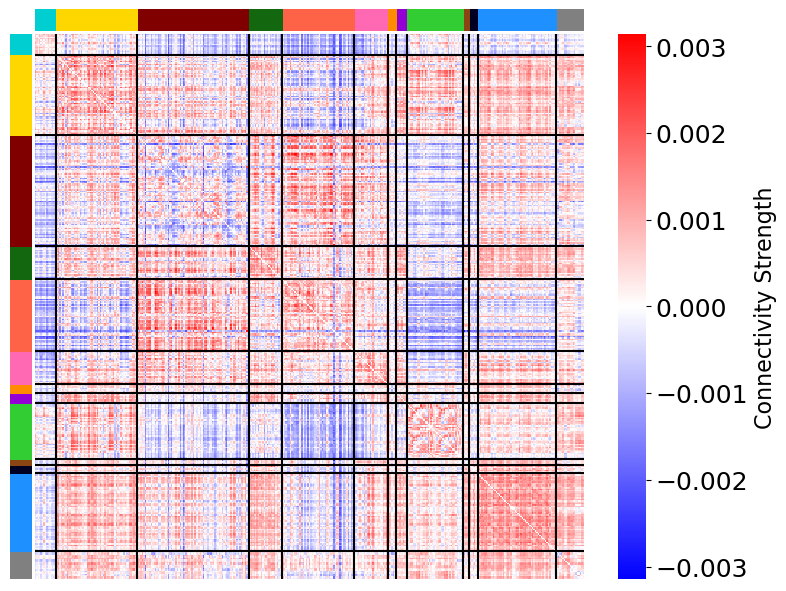

In [ ]:
import seaborn as sns
import matplotlib.patches as patches

# Create a figure and axes for heatmap and functional network labels
fig, ax = plt.subplots(figsize=(8, 6))
max_abs_value = np.max(sorted_adj_matrix)

# Plot the heatmap using seaborn without tick labels
sns.heatmap(
    sorted_adj_matrix,
    cmap=colormap,              # Use the same colormap you defined earlier
    vmin=-max_abs_value,          # Symmetric lower limit
    vmax=max_abs_value,           # Symmetric upper limit
    xticklabels=False,          # Remove x-axis tick labels
    yticklabels=False,          # Remove y-axis tick labels
    # cbar_kws={'fontsize': 15},  # Label for the color bar
    ax=ax
)
# # Access the color bar to adjust font sizes
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=15)  # Change the font size of the color bar ticks
# cbar.ax.set_ylabel('Connectivity Strength', fontsize=15)
# Function to add color bars for functional network labels
def add_network_colorbar(ax, sorted_rois, roi_network_df, manual_network_colors):
    # Extract the network labels for each sorted ROI
    roi_networks = roi_network_df.set_index('name_Glasser').loc[sorted_rois]['Cole_net_name'].values
    
    # Create color bars based on the network each ROI belongs to
    top_colors = [manual_network_colors[network] for network in roi_networks]  # Top color bar (x-axis)
    side_colors = [manual_network_colors[network] for network in roi_networks]  # Side color bar (y-axis)

    # Add color bar to the top
    for i, color in enumerate(top_colors):
        ax.add_patch(patches.Rectangle((i, -17), 1, 15, facecolor=color, transform=ax.transData,
                                       clip_on=False, linewidth=0))

    # Add color bar to the left
    for i, color in enumerate(side_colors):
        ax.add_patch(patches.Rectangle((-17, i), 15, 1, facecolor=color, transform=ax.transData,
                                       clip_on=False, linewidth=0))
    return roi_networks
# Call the function to add the color bars
roi_networks = add_network_colorbar(ax, sorted_rois, roi_network_df, manual_network_colors)

# Add grid lines based on the network partitions
# Get unique network indices for vertical and horizontal lines
unique_networks = roi_network_df['Cole_net_name'].unique()
network_indices = []

for i, network in enumerate(roi_network_df['Cole_net_name']):
    if i == 0 or network != roi_network_df['Cole_net_name'].iloc[i - 1]:
        network_indices.append(i)

# Draw vertical grid lines
for idx in network_indices:
    ax.axvline(x=idx - 0.5, color='k', linewidth=1.5, linestyle='-')  # Vertical lines

# Draw horizontal grid lines
for idx in network_indices:
    ax.axhline(y=idx - 0.5, color='k', linewidth=1.5, linestyle='-')  # Horizontal lines
# Access the color bar from the heatmap
cbar = ax.collections[0].colorbar

# Increase the font size of the color bar ticks
cbar.ax.tick_params(labelsize=18)  

#  set a label for the color bar and increase its font size
cbar.set_label('Connectivity Strength', fontsize=16)  

# Add title to the plot
# plt.title("Brain Connectivity Heatmap with Functional Network Labels", fontsize=14)

# Adjust layout to make room for the colored bars
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# save ranked weights 
from itertools import combinations

# Assuming:
# - sorted_adj_matrix is connectivity matrix (N x N, where N is the number of ROIs)
# - roi_networks is an array of length N, where each element is the network label for the corresponding ROI
# - networks are labeled as strings (e.g., 'Default', 'Visual', etc.)

# Get unique networks
unique_networks = np.unique(roi_networks)
n_networks = len(unique_networks)

# Initialize a list to store results
results = []

# Iterate through all unique pairs of networks
for net1, net2 in combinations(unique_networks, 2):
    # Find indices of ROIs in each network
    net1_indices = np.where(roi_networks == net1)[0]
    net2_indices = np.where(roi_networks == net2)[0]
    
    # Extract the submatrix for the pair of networks
    submatrix = sorted_adj_matrix[np.ix_(net1_indices, net2_indices)]
    print(submatrix.shape)
    # Calculate the average coefficient for this pair
    avg_coefficient = np.mean(submatrix)
    std_coefficient = np.std(submatrix)
    
    # Store the result
    results.append({'Network Pair': f'{net1}-{net2}', 'Average Coefficient': avg_coefficient, 'std': std_coefficient})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the DataFrame by the average coefficient
results_df = results_df.sort_values(by='Average Coefficient', ascending=False)


In [ ]:
results_df.to_csv(plot_dir +  'mid_conn_avefi_ranked.csv')
results_df

,Network Pair,Average Coefficient,std
36,Dorsal_Attention-Posterior_Multimodal,0.000892,0.000457
17,Cingulo-Opercular-Posterior_Multimodal,0.000831,0.000489
77,Visual1-Visual2,0.000805,0.000469
76,Ventral_Multimodal-Visual2,0.000785,0.000268
67,Posterior_Multimodal-Visual2,0.000776,0.000394
...,...,...,...
2,Auditory-Dorsal_Attention,-0.000513,0.000459
1,Auditory-Default,-0.000568,0.000526
4,Auditory-Language,-0.000654,0.000514
45,Frontoparietal-Somatomotor,-0.000794,0.000620


### Best contrast-based model

In [ ]:
root_dir = '/media/hcs-sci-psy-narun/ABCC/fmriresults01/derivatives/ML_Tables/nesi_outputs/std_applicability/'
targ_list = ['total_'] #'total_', 'cryst_','fluid_'
model_list = ['enet1']#,'pls'
for model in model_list:
      for targ in targ_list:
            en_outs = joblib.load(root_dir + targ + 'cntr_' + model + '_output_fstd.joblib')

/home/farzane/anaconda3/envs/nilearn_py11/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


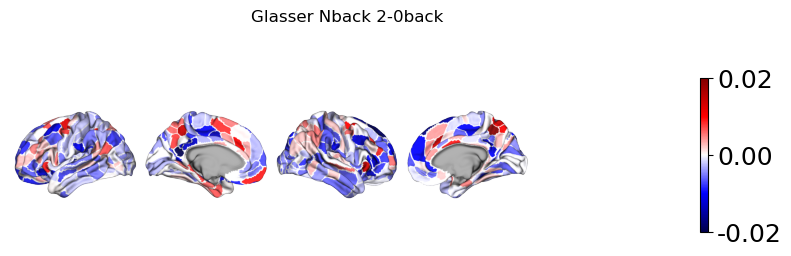

In [ ]:
# Required imports
import hcp_utils as hcp
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
# Step 1: Load the surfaces and data
nback_coef = en_outs['cntr_twobk-zerobk_task-nback']['model']['best_model'].coef_

sample_array = nback_coef  # Parcelated activation array
unparced_map = hcp.unparcellate(sample_array, hcp.mmp)  # Get full brain from parcelated data
cortx = hcp.cortex_data(unparced_map)        # Extract full cortex data
L_cortx = hcp.left_cortex_data(unparced_map)   # Extract left hemisphere
R_cortx = hcp.right_cortex_data(unparced_map)  # Extract right hemisphere

surfaces = fetch_fslr()  # Fetch midthickness surfaces
lh, rh = surfaces['midthickness']  # Left and right hemisphere surfaces

# Step 2: Create the plot using surfplot
p = Plot(lh, rh, size=(800, 200), zoom=1.2, layout='row')

# Step 3: Add the main layer with beta weights and colormap
p.add_layer({'left': L_cortx, 'right': R_cortx}, cbar=False, cmap='seismic')

# Step 4: Optionally add an outline layer for context
p.add_layer({'left': L_cortx, 'right': R_cortx}, cmap='gray', as_outline=True, cbar=False)

# Step 5: Build the plot
fig = p.build()

# Step 6: Modify the colorbar to make it vertical and increase the font size
# First, remove the default horizontal colorbar
for ax in fig.axes:
    if ax.get_position().x1 == 0.95:  # Surfplot typically places the colorbar here
        fig.delaxes(ax)

# Step 7: Create a new vertical colorbar on the right side
sm = plt.cm.ScalarMappable(cmap='seismic')
sm.set_array([sample_array.min(), sample_array.max()])  # Set colorbar range based on the data

# Add the new vertical colorbar
cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.011, pad=0.24)
cbar.ax.tick_params(labelsize=18) 

# Step 8: Set 5 ticks, including min and max values
ticks = np.linspace(sample_array.min(), sample_array.max(), 3)  # 5 evenly spaced ticks
cbar.set_ticks(ticks)
# Step 9: Format colorbar ticks to 2 decimal places
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# Add a title to the figure
plt.suptitle('Glasser Nback 2-0back')

# Show the plot with the customized colorbar
plt.show()


subc


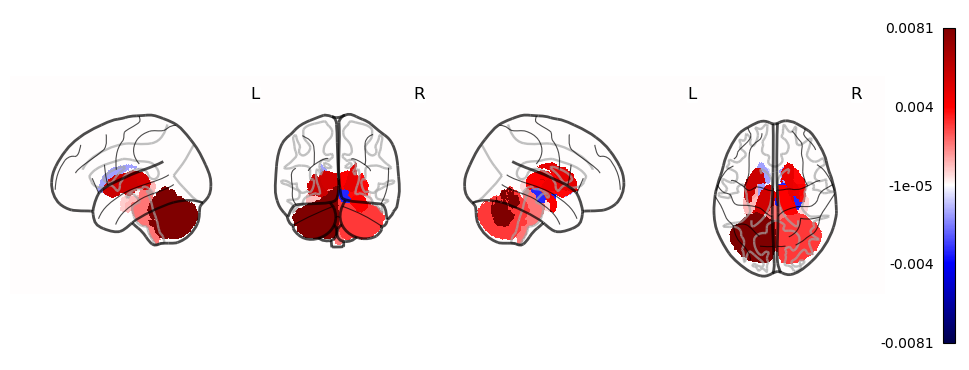

In [ ]:
# plot subcortex
from nilearn import image as nli
from nilearn import plotting
#load atlases
wway = '/media/hcs-sci-psy-narun/Alina/atlases/'
atlas2 = nli.load_img(wway+'subc2.fs.nii.gz')

par_dat2 = atlas2.get_fdata()

#empty image in the same way as reffered atlas
par_dat2 = atlas2.get_fdata()
site_nii2 = np.zeros(par_dat2.shape)
#reorder subc table into atlas order
dtvc = nback_coef[360:]
#std
vec2 =pd.Series(dtvc, index=pd.read_csv(wway+'atlas_index_num.txt')['nn'].values )
#fill mat with numbers
for index, numb in zip(vec2.index, vec2.iloc[:]): 
    site_nii2[par_dat2 == (index)] = numb
#create image object
site_img2 = nli.new_img_like(atlas2, site_nii2, atlas2.affine, copy_header=True)
#display
print('subc')
display_subc = plotting.plot_glass_brain(site_img2, plot_abs=False, cmap='seismic',  #different colormap
                                         colorbar=True, display_mode='lyrz', 
                                         symmetric_cbar=True)


In [ ]:
# save weights 
# Step 1: Load the region names and weights
region_names = list(hcp.mmp.labels.values())[1:] # Get region labels from Glasser atlas
weights = nback_coef  

# Step 2: Create a DataFrame
region_weights_df = pd.DataFrame({'Region': region_names, 'Weight': weights})

# Step 3: Sort by absolute weight value (descending order)
region_weights_df = region_weights_df.reindex(region_weights_df['Weight'].sort_values(ascending=False).index)

# Step 4: Display the sorted table
print(region_weights_df.to_string(index=False))
region_weights_df.to_csv(plot_dir + '2-0back-enetw.csv')

            Region    Weight
             R_PCV  0.023299
             L_PCV  0.018425
           R_a32pr  0.017640
             R_AVI  0.017594
              L_6a  0.017020
             R_7Pm  0.014579
            R_i6-8  0.014505
             R_7Am  0.014188
              R_6a  0.013995
           L_a32pr  0.012544
             L_AIP  0.012478
             L_FEF  0.012260
            R_33pr  0.011713
             L_AVI  0.011596
             L_10v  0.011531
             L_IP2  0.011397
              R_46  0.011150
            L_SCEF  0.010778
            L_PreS  0.010223
             L_55b  0.010208
              L_7m  0.010037
            L_s6-8  0.009654
             L_PGi  0.009346
            L_PeEc  0.009264
              L_EC  0.008515
             L_7Am  0.008409
             L_7Pm  0.008365
            R_p10p  0.008278
             L_MIP  0.008247
              R_A5  0.008213
             R_55b  0.008104
  cerebellum_right  0.008056
             R_AIP  0.008024
             R

### Best sMRI-based model

In [ ]:
root_dir = '/media/hcs-sci-psy-narun/ABCC/fmriresults01/derivatives/ML_Tables/nesi_outputs/std_applicability/'
targ_list = ['total_'] #'total_', 'cryst_','fluid_'
model_list = ['enet1']#,'pls'
for model in model_list:
      for targ in targ_list:
            en_outs = joblib.load(root_dir + targ + 'smri_' + model + '_output_fstd.joblib')

t2_int_coef = en_outs['T2_gray']['model']['best_model'].coef_
# add 'Medial_wall' to left and right to match Destrieux labels
t2_int_coef1 = np.insert(t2_int_coef, 41, 0)
t2_int_coef2 = np.insert(t2_int_coef1,114, 0)

/tmp/ipykernel_7043/4275221610.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


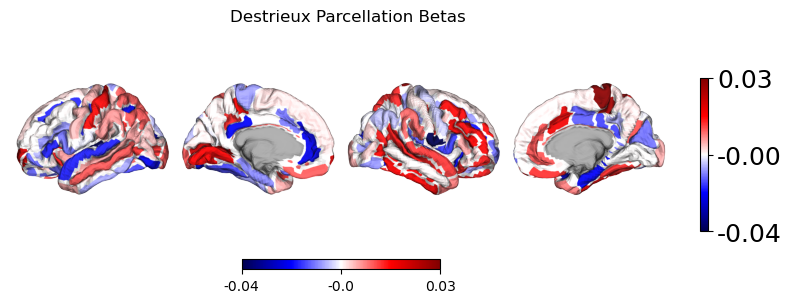

In [ ]:
import numpy as np
from nilearn.datasets import fetch_surf_fsaverage, fetch_atlas_surf_destrieux
from nilearn.surface import load_surf_data
from surfplot import Plot
import matplotlib.pyplot as plt
from neuromaps.datasets import fetch_fslr

# Step 1: Fetch surfaces and destrieux parcellation at fsaverage5 (10k vertices per hemisphere)
fsaverage = fetch_surf_fsaverage(mesh='fsaverage5')  # Use fsaverage5 for the correct resolution
lh, rh = fsaverage['pial_left'], fsaverage['pial_right']  # Left and right hemisphere inflated surfaces
# surfaces = fetch_fslr()
# lh, rh = surfaces['inflated']
# Fetch Destrieux atlas
destrieux_atlas = fetch_atlas_surf_destrieux()

# Load parcellation data for both hemispheres
L_cortx_labels = load_surf_data(destrieux_atlas['map_left'])  # Shape (10242,)
R_cortx_labels = load_surf_data(destrieux_atlas['map_right'])  # Shape (10242,)

# Step 2: beta weights 
beta_values = t2_int_coef2  # 

# Step 3: Map beta weights to each vertex in the cortex using the parcellation labels
L_cortx_beta = np.zeros_like(L_cortx_labels, dtype=float)  # Initialize left hemisphere beta array
R_cortx_beta = np.zeros_like(R_cortx_labels, dtype=float)  # Initialize right hemisphere beta array

# Map the 148 beta values to the cortical labels
for label in np.unique(L_cortx_labels):
    L_cortx_beta[L_cortx_labels == label] = beta_values[int(label) - 1]  # label-1 because of 1-indexed labels

for label in np.unique(R_cortx_labels):
        
        st_index = int(label) + 73
        # print(destrieux_atlas.labels[int(label)], label, st_index)
        R_cortx_beta[R_cortx_labels == label] = beta_values[st_index - 1]

# Step 4: Plot using surfplot (same approach as before)
p = Plot(lh, rh, size=(800, 200), zoom=1.2, layout='row')

# Add main layer with beta weights and colormap
p.add_layer({'left': L_cortx_beta, 'right': R_cortx_beta}, cbar=True, cmap='seismic')

#  add an outline layer for context
p.add_layer({'left': L_cortx_beta, 'right': R_cortx_beta}, cmap='gray', as_outline=True, cbar=False)

# Build and show the plot
fig = p.build()
# Step 6: Modify the colorbar to make it vertical and increase the font size
# First, remove the default horizontal colorbar
for ax in fig.axes:
    if ax.get_position().x1 == 0.95:  #  
        fig.delaxes(ax)

# Step 7: Create a new vertical colorbar on the right side
sm = plt.cm.ScalarMappable(cmap='seismic')
sm.set_array([beta_values.min(), beta_values.max()])  # Set colorbar range based on the data

# Add the new vertical colorbar
cbar = fig.colorbar(sm, ax=fig.axes, orientation='vertical', fraction=0.011, pad=0.04)
cbar.ax.tick_params(labelsize=18) 

# Step 8: Set 5 ticks, including min and max values
ticks = np.linspace(beta_values.min(), beta_values.max(), 3)  # 5 evenly spaced ticks
cbar.set_ticks(ticks)
# Step 9: Format colorbar ticks to 2 decimal places
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.suptitle('Destrieux Parcellation Betas')
fig.show()


In [ ]:
# save weights 
import pandas as pd

# Extract region names (skip the first entry, which is 'unknown')
region_names = destrieux_atlas['labels'][1:]  # Remove 'unknown' at index 0

# Create a mapping of labels to beta values
region_beta_values = []
for label in np.unique(L_cortx_labels):
    if label == 0:  # Skip background label
        continue
    region_name = region_names[int(label) - 1]  # Adjust for 1-based index
    beta_value = beta_values[int(label) - 1]  # Adjust for 1-based index
    region_beta_values.append((region_name, beta_value))

for label in np.unique(R_cortx_labels):
    if label == 0:  # Skip background label
        continue
    region_name = region_names[int(label) - 1]  # Adjust for 1-based index
    beta_value = beta_values[int(label) + 73 - 1]  # Adjust for 1-based index
    region_beta_values.append((region_name, beta_value))

# Convert to DataFrame and sort
df = pd.DataFrame(region_beta_values, columns=["Region", "Beta Coefficient"])
df = df.sort_values(by="Beta Coefficient", ascending=False)  # Sort by absolute beta

df.to_csv(plot_dir + 't2grayintensity-enetw.csv')


In [ ]:
df

,Region,Beta Coefficient
77,b'G_and_S_paracentral',0.029794
121,b'S_cingul-Marginalis',0.026014
63,b'S_orbital_med-olfact',0.025327
44,b'S_calcarine',0.021682
4,b'G_and_S_transv_frontopol',0.020696
...,...,...
51,b'S_collat_transv_post',-0.026564
109,b'G_temp_sup-Plan_polar',-0.026828
58,b'S_oc_sup_and_transversal',-0.031030
32,b'G_temp_sup-G_T_transv',-0.033055
